In [4]:
"""
Cell 1: Complete Setup with Gymnasium 1.0+

"""

print("🔧 Setting up Atari environment (forcing gymnasium 1.0+)...")
print("="*70)

import sys

# CRITICAL: Force gymnasium 1.0+ where ALE registration works properly
print("📦 Installing gymnasium 1.0+ and ALE...")
!{sys.executable} -m pip uninstall -y gymnasium ale-py shimmy >/dev/null 2>&1
!{sys.executable} -m pip install -q gymnasium>=1.0.0
!{sys.executable} -m pip install -q "gymnasium[atari,accept-rom-license]"
!{sys.executable} -m pip install -q ale-py

print("✅ Packages installed (gymnasium 1.0+)")

# Core imports
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import gymnasium and ale_py
import gymnasium as gym
import ale_py

# Register Atari environments
print("🎮 Registering Atari environments...")
gym.register_envs(ale_py)

# Verify registration
registered = list(gym.envs.registry.keys())
atari_envs = [e for e in registered if 'ALE/' in e]
donkey_envs = [e for e in registered if 'Donkey' in e or 'donkey' in e]

print(f"✅ Total Atari environments: {len(atari_envs)}")
print(f"✅ DonkeyKong variants: {donkey_envs}")

if 'ALE/DonkeyKong-v5' not in registered:
    print(f"\n❌ ALE/DonkeyKong-v5 still not found!")
    print(f"Sample Atari envs: {atari_envs[:5]}")
    raise RuntimeError("ALE registration failed - restart kernel and try again")

# Test environment
print(f"\n🧪 Testing ALE/DonkeyKong-v5...")
test_env = gym.make("ALE/DonkeyKong-v5")
print(f"✅ Environment working!")
print(f"   Actions: {test_env.action_space.n}")
print(f"   Obs shape: {test_env.observation_space.shape}")
test_env.close()

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n💻 Device: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Random seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print(f"\n{'='*70}")
print(f"✅✅✅ SETUP COMPLETE! ALE/DonkeyKong-v5 ready!")
print(f"{'='*70}\n")

🔧 Setting up Atari environment (forcing gymnasium 1.0+)...
📦 Installing gymnasium 1.0+ and ALE...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires shimmy>=1.2.1, which is not installed.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, which is not installed.
stable-baselines3 2.1.0 requires gymnasium<0.30,>=0.28.1, but you have gymnasium 1.2.2 which is incompatible.
kaggle-environments 1.18.0 requires gymnasium==0.29.0, but you have gymnasium 1.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 58.7 MB/s eta 0:00:0000:0100:01
✅ Packages installed (gymnasium 1.0+)
🎮 Registering Atari environments...
✅ Total Atari environments: 104
✅ DonkeyKong variants: ['ALE/DonkeyKong-v5']

🧪 Testing ALE/DonkeyKong-v5...
✅ Environment working!
   Actions: 18
   Obs shape: (210, 160, 3)


A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]



💻 Device: cuda
   GPU: Tesla P100-PCIE-16GB
   Memory: 17.06 GB

✅✅✅ SETUP COMPLETE! ALE/DonkeyKong-v5 ready!



In [5]:
"""
Hyperparameter Configuration
These values establish the baseline performance as required by the rubric.
Variations will be tested in subsequent experiments.
"""

class DQNConfig:
    # Environment
    ENV_NAME = "ALE/DonkeyKong-v5"
    
    # Training
    TOTAL_EPISODES = 5000
    MAX_STEPS_PER_EPISODE = 1000
    BATCH_SIZE = 32
    
    # Learning parameters (Bellman equation)
    LEARNING_RATE = 0.00025  # Alpha in Adam optimizer
    GAMMA = 0.99             # Discount factor in Bellman equation
    
    # Exploration parameters (ε-greedy policy)
    EPSILON_START = 1.0
    EPSILON_MIN = 0.1
    EPSILON_DECAY = 0.995    # Exponential decay per episode
    
    # Replay buffer
    REPLAY_BUFFER_SIZE = 50000
    MIN_REPLAY_SIZE = 10000  # Warmup before training starts
    
    # Network updates
    TARGET_UPDATE_FREQ = 1000  # Steps between target network updates
    
    # Checkpoint management
    SAVE_FREQ = 500  # Save every N episodes
    CHECKPOINT_DIR = "/kaggle/working/checkpoints"
    
    # Frame preprocessing
    FRAME_WIDTH = 84
    FRAME_HEIGHT = 84
    FRAME_STACK_SIZE = 4  # Number of frames to stack
    
    # Logging
    LOG_FREQ = 10  # Print stats every N episodes
    EVAL_FREQ = 100  # Evaluate agent every N episodes

# Create checkpoint directory
os.makedirs(DQNConfig.CHECKPOINT_DIR, exist_ok=True)

print("Configuration loaded:")
print(f"  Environment: {DQNConfig.ENV_NAME}")
print(f"  Episodes: {DQNConfig.TOTAL_EPISODES}")
print(f"  Learning Rate (α): {DQNConfig.LEARNING_RATE}")
print(f"  Discount Factor (γ): {DQNConfig.GAMMA}")
print(f"  Epsilon Decay: {DQNConfig.EPSILON_DECAY}")

Configuration loaded:
  Environment: ALE/DonkeyKong-v5
  Episodes: 5000
  Learning Rate (α): 0.00025
  Discount Factor (γ): 0.99
  Epsilon Decay: 0.995


In [6]:
"""
Frame Preprocessing Pipeline
Converts raw Atari frames (210x160x3 RGB) to (84x84) grayscale.
Rationale: Reduces dimensionality while preserving spatial features.
"""

class FramePreprocessor:
    def __init__(self, width=84, height=84):
        self.width = width
        self.height = height
    
    def preprocess(self, frame):
        """
        Preprocess a single frame.
        
        Args:
            frame: numpy array (210, 160, 3) with values [0, 255]
        
        Returns:
            Preprocessed frame: numpy array (84, 84) with values [0, 1]
        """
        # Convert to grayscale using luminosity method
        # Y = 0.299*R + 0.587*G + 0.114*B
        gray = np.dot(frame[..., :3], [0.299, 0.587, 0.114])
        
        # Resize to 84x84 using PIL for better quality
        img = Image.fromarray(gray.astype(np.uint8))
        img = img.resize((self.width, self.height), Image.BILINEAR)
        
        # Normalize to [0, 1]
        processed = np.array(img, dtype=np.float32) / 255.0
        
        return processed

# Test preprocessing
preprocessor = FramePreprocessor()
print(f"Preprocessor initialized: {DQNConfig.FRAME_HEIGHT}x{DQNConfig.FRAME_WIDTH}")

Preprocessor initialized: 84x84


In [7]:
"""
Frame Stacker
Maintains a stack of the last N preprocessed frames.
Provides temporal information (velocity, acceleration) to the agent.
"""

class FrameStack:
    def __init__(self, stack_size=4):
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)
    
    def reset(self, initial_frame):
        """Initialize stack with the same frame repeated."""
        self.frames.clear()
        for _ in range(self.stack_size):
            self.frames.append(initial_frame)
    
    def push(self, frame):
        """Add new frame to stack."""
        self.frames.append(frame)
    
    def get_state(self):
        """
        Get current stacked state.
        
        Returns:
            numpy array of shape (stack_size, height, width)
        """
        return np.array(self.frames, dtype=np.float32)

print(f"Frame stacker configured: {DQNConfig.FRAME_STACK_SIZE} frames")

Frame stacker configured: 4 frames


In [8]:
"""
Experience Replay Buffer
Stores transitions and samples random minibatches for training.
Breaks temporal correlation in sequential experiences.
"""

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        """
        Store a transition.
        
        Args:
            state: (4, 84, 84) stacked frames
            action: int
            reward: float
            next_state: (4, 84, 84) stacked frames
            done: bool
        """
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """
        Sample random minibatch.
        
        Returns:
            Tuple of batched tensors: (states, actions, rewards, next_states, dones)
        """
        batch = random.sample(self.buffer, batch_size)
        
        states, actions, rewards, next_states, dones = zip(*batch)
        
        return (
            torch.FloatTensor(np.array(states)).to(device),
            torch.LongTensor(actions).to(device),
            torch.FloatTensor(rewards).to(device),
            torch.FloatTensor(np.array(next_states)).to(device),
            torch.FloatTensor(dones).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)
    
    def save(self, filepath):
        """Save buffer to disk for checkpoint recovery."""
        torch.save(list(self.buffer), filepath)
        print(f"Replay buffer saved: {len(self.buffer)} transitions")
    
    def load(self, filepath):
        """Load buffer from disk."""
        self.buffer = deque(torch.load(filepath), maxlen=self.buffer.maxlen)
        print(f"Replay buffer loaded: {len(self.buffer)} transitions")

print(f"Replay buffer capacity: {DQNConfig.REPLAY_BUFFER_SIZE:,}")

Replay buffer capacity: 50,000


In [9]:
"""
Deep Q-Network Architecture
Convolutional neural network for processing stacked Atari frames.

Architecture (based on Mnih et al. 2015):
- Conv1: 32 filters, 8x8 kernel, stride 4
- Conv2: 64 filters, 4x4 kernel, stride 2
- Conv3: 64 filters, 3x3 kernel, stride 1
- FC1: 512 units
- Output: Q-values for each action
"""

class DQNNetwork(nn.Module):
    def __init__(self, input_shape, num_actions):
        """
        Args:
            input_shape: (channels, height, width) e.g., (4, 84, 84)
            num_actions: int, size of action space
        """
        super(DQNNetwork, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Calculate size after convolutions
        def conv2d_size_out(size, kernel_size, stride):
            return (size - kernel_size) // stride + 1
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[2], 8, 4), 4, 2), 3, 1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(input_shape[1], 8, 4), 4, 2), 3, 1)
        linear_input_size = convw * convh * 64
        
        # Fully connected layers
        self.fc1 = nn.Linear(linear_input_size, 512)
        self.fc2 = nn.Linear(512, num_actions)
    
    def forward(self, x):
        """
        Forward pass.
        
        Args:
            x: (batch, 4, 84, 84) stacked frames
        
        Returns:
            Q-values: (batch, num_actions)
        """
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize networks
env = gym.make(DQNConfig.ENV_NAME)
num_actions = env.action_space.n
input_shape = (DQNConfig.FRAME_STACK_SIZE, DQNConfig.FRAME_HEIGHT, DQNConfig.FRAME_WIDTH)

q_network = DQNNetwork(input_shape, num_actions).to(device)
target_network = DQNNetwork(input_shape, num_actions).to(device)
target_network.load_state_dict(q_network.state_dict())
target_network.eval()  # Target network in eval mode

print(f"Q-Network initialized:")
print(f"  Input shape: {input_shape}")
print(f"  Output actions: {num_actions}")
print(f"  Total parameters: {sum(p.numel() for p in q_network.parameters()):,}")

Q-Network initialized:
  Input shape: (4, 84, 84)
  Output actions: 18
  Total parameters: 1,693,362


In [10]:
"""
Checkpoint Management (Corruption-Resistant Version)
Gracefully handles corrupted replay buffer files.
"""

import pickle

class CheckpointManager:
    def __init__(self, checkpoint_dir):
        self.checkpoint_dir = checkpoint_dir
    
    def save_checkpoint(self, episode, q_network, target_network, optimizer, 
                       replay_buffer, epsilon, rewards_history, steps_history):
        """Save complete training state."""
        checkpoint_path = os.path.join(
            self.checkpoint_dir, 
            f"checkpoint_episode_{episode}.pth"
        )
        
        # Save models and training state
        torch.save({
            'episode': episode,
            'q_network_state_dict': q_network.state_dict(),
            'target_network_state_dict': target_network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epsilon': epsilon,
            'rewards_history': rewards_history,
            'steps_history': steps_history,
            'config': {
                'learning_rate': DQNConfig.LEARNING_RATE,
                'gamma': DQNConfig.GAMMA,
                'epsilon_decay': DQNConfig.EPSILON_DECAY,
            }
        }, checkpoint_path)
        
        # Save replay buffer separately (with error handling)
        buffer_path = os.path.join(
            self.checkpoint_dir,
            f"replay_buffer_episode_{episode}.pth"
        )
        
        try:
            replay_buffer.save(buffer_path)
            buffer_saved = True
        except Exception as e:
            print(f"⚠️ Warning: Could not save replay buffer: {e}")
            buffer_saved = False
        
        print(f"\n{'='*60}")
        print(f"CHECKPOINT SAVED: Episode {episode}")
        print(f"  Model: {checkpoint_path}")
        if buffer_saved:
            print(f"  Buffer: {buffer_path}")
        else:
            print(f"  Buffer: FAILED TO SAVE")
        print(f"  Epsilon: {epsilon:.4f}")
        print(f"  Avg Reward (last 100): {np.mean(rewards_history[-100:]):.2f}")
        print(f"{'='*60}\n")
    
    def load_checkpoint(self, checkpoint_path, q_network, target_network, 
                       optimizer, replay_buffer):
        """
        Load training state from checkpoint.
        Gracefully handles corrupted or missing replay buffer files.
        
        Returns:
            Dictionary with: episode, epsilon, rewards_history, steps_history
        """
        print(f"Loading checkpoint: {checkpoint_path}")
        
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        q_network.load_state_dict(checkpoint['q_network_state_dict'])
        target_network.load_state_dict(checkpoint['target_network_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        episode = checkpoint['episode']
        epsilon = checkpoint['epsilon']
        rewards_history = checkpoint['rewards_history']
        steps_history = checkpoint['steps_history']
        
        # Try to load replay buffer (skip if corrupted or missing)
        buffer_path = checkpoint_path.replace('checkpoint_', 'replay_buffer_')
        buffer_loaded = False
        
        if os.path.exists(buffer_path):
            try:
                replay_buffer.load(buffer_path)
                buffer_loaded = True
                print(f"✓ Replay buffer loaded: {len(replay_buffer)} transitions")
            except (EOFError, RuntimeError, pickle.UnpicklingError, Exception) as e:
                print(f"⚠️ Replay buffer corrupted or incomplete: {type(e).__name__}")
                print(f"  Error: {e}")
                print(f"  Continuing with empty buffer (will rebuild during training)")
                replay_buffer.buffer.clear()
        else:
            print(f"⚠️ Replay buffer file not found: {buffer_path}")
            print(f"  Continuing with empty buffer (will rebuild during training)")
        
        print(f"\nCheckpoint loaded successfully!")
        print(f"  Resuming from episode: {episode}")
        print(f"  Epsilon: {epsilon:.4f}")
        print(f"  Buffer status: {'LOADED' if buffer_loaded else 'EMPTY (will rebuild)'}")
        
        return {
            'episode': episode,
            'epsilon': epsilon,
            'rewards_history': rewards_history,
            'steps_history': steps_history
        }
    
    def get_latest_checkpoint(self):
        """Find the most recent checkpoint file."""
        checkpoints = [f for f in os.listdir(self.checkpoint_dir) 
                      if f.startswith('checkpoint_episode_')]
        
        if not checkpoints:
            return None
        
        # Extract episode numbers and find max
        episodes = [int(f.split('_')[-1].replace('.pth', '')) 
                   for f in checkpoints]
        latest_episode = max(episodes)
        
        return os.path.join(
            self.checkpoint_dir,
            f"checkpoint_episode_{latest_episode}.pth"
        )

checkpoint_manager = CheckpointManager(DQNConfig.CHECKPOINT_DIR)
print("Checkpoint manager initialized (corruption-resistant)")

Checkpoint manager initialized (corruption-resistant)


In [11]:
"""
DQN Training Agent
Implements the Deep Q-Learning algorithm with experience replay and target networks.

TODO SECTIONS: You must implement the Q-value computation and loss calculation.
This is where you demonstrate understanding of the Bellman equation.
"""

class DQNAgent:
    def __init__(self, q_network, target_network, optimizer, replay_buffer, config):
        self.q_network = q_network
        self.target_network = target_network
        self.optimizer = optimizer
        self.replay_buffer = replay_buffer
        self.config = config
        
        self.total_steps = 0
        self.epsilon = config.EPSILON_START
    
    def select_action(self, state, evaluation=False):
        """
        ε-greedy action selection.
        
        Args:
            state: (4, 84, 84) stacked frames
            evaluation: If True, use greedy policy (no exploration)
        
        Returns:
            action: int
        """
        if evaluation or random.random() > self.epsilon:
            # Greedy action
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax(dim=1).item()
        else:
            # Random exploration
            action = random.randint(0, num_actions - 1)
        
        return action
    
    def train_step(self):
        """
        Perform one training step: sample batch and update Q-network.
        
        Returns:
            loss: float, TD error
        """
        if len(self.replay_buffer) < self.config.MIN_REPLAY_SIZE:
            return None  # Not enough samples yet
        
        # Sample minibatch
        states, actions, rewards, next_states, dones = \
            self.replay_buffer.sample(self.config.BATCH_SIZE)
        
        # ============================================================
        # TODO: Implement Q-value computation (5 points in rubric)
        # ============================================================
        # Hint: Use the Bellman equation:
        # Q(s,a) = r + γ * max_a' Q_target(s', a') * (1 - done)
        #
        # Steps:
        # 1. Compute current Q-values: Q(s,a) for taken actions
        # 2. Compute next Q-values using target_network: max_a' Q_target(s', a')
        # 3. Compute target: r + γ * next_q_values * (1 - done)
        # 4. Calculate loss: MSE between current_q and target_q
        # 5. Backpropagate and update weights
        # ============================================================
        
        # Step 1: Get Q(s,a) for actions that were taken
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))
        
        # Step 2: Get max Q(s',a') from target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            # Step 3: Compute target using Bellman equation
            target_q_values = rewards + (self.config.GAMMA * next_q_values * (1 - dones))
        
        # Step 4: Compute loss (Mean Squared Error)
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Step 5: Optimize
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=10)
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        """Copy Q-network weights to target network."""
        self.target_network.load_state_dict(self.q_network.state_dict())
    
    def decay_epsilon(self):
        """Decay exploration rate (called after each episode)."""
        self.epsilon = max(
            self.config.EPSILON_MIN,
            self.epsilon * self.config.EPSILON_DECAY
        )

# Initialize agent components
optimizer = optim.Adam(q_network.parameters(), lr=DQNConfig.LEARNING_RATE)
replay_buffer = ReplayBuffer(DQNConfig.REPLAY_BUFFER_SIZE)

agent = DQNAgent(
    q_network=q_network,
    target_network=target_network,
    optimizer=optimizer,
    replay_buffer=replay_buffer,
    config=DQNConfig
)

print("DQN Agent initialized and ready for training")

DQN Agent initialized and ready for training


In [12]:
"""
Memory-Optimized Training Loop
Fixes: Replay buffer serialization, checkpoint cleanup, history truncation.
"""

def train_dqn_memory_optimized(resume_from_checkpoint=True, max_checkpoints=3):
    """
    Train DQN agent with memory management.
    
    Args:
        resume_from_checkpoint: If True, load latest checkpoint and continue
        max_checkpoints: Keep only the last N checkpoints (delete old ones)
    """
    # Initialize environment
    env = gym.make(DQNConfig.ENV_NAME)
    preprocessor = FramePreprocessor(DQNConfig.FRAME_WIDTH, DQNConfig.FRAME_HEIGHT)
    frame_stack = FrameStack(DQNConfig.FRAME_STACK_SIZE)
    
    # Training state
    start_episode = 0
    rewards_history = []
    steps_history = []
    losses = []
    
    # Resume from checkpoint if requested
    if resume_from_checkpoint:
        latest_checkpoint = checkpoint_manager.get_latest_checkpoint()
        if latest_checkpoint:
            state = checkpoint_manager.load_checkpoint(
                latest_checkpoint, q_network, target_network, optimizer, replay_buffer
            )
            start_episode = state['episode']
            agent.epsilon = state['epsilon']
            rewards_history = state['rewards_history']
            steps_history = state['steps_history']
            
            # CRITICAL: Clear old variables to free memory
            del state
            import gc
            gc.collect()
            torch.cuda.empty_cache() if torch.cuda.is_available() else None
        else:
            print("No checkpoint found. Starting from scratch.")
    
    print(f"\n{'='*60}")
    print(f"TRAINING START")
    print(f"{'='*60}")
    print(f"Episodes: {start_episode} → {DQNConfig.TOTAL_EPISODES}")
    print(f"Initial epsilon: {agent.epsilon:.4f}")
    print(f"Replay buffer size: {len(replay_buffer)}")
    print(f"{'='*60}\n")
    
    start_time = time.time()
    
    # Training loop
    for episode in range(start_episode, DQNConfig.TOTAL_EPISODES):
        # Reset environment
        state, info = env.reset(seed=SEED + episode)
        state = preprocessor.preprocess(state)
        frame_stack.reset(state)
        current_state = frame_stack.get_state()
        
        episode_reward = 0
        episode_steps = 0
        episode_losses = []
        
        # Episode loop
        for step in range(DQNConfig.MAX_STEPS_PER_EPISODE):
            # Select and execute action
            action = agent.select_action(current_state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            
            # Preprocess and update frame stack
            next_state = preprocessor.preprocess(next_state)
            frame_stack.push(next_state)
            next_state_stack = frame_stack.get_state()
            
            # Store transition in replay buffer
            replay_buffer.push(current_state, action, reward, next_state_stack, float(done))
            
            # Train agent
            loss = agent.train_step()
            if loss is not None:
                episode_losses.append(loss)
            
            # Update target network periodically
            agent.total_steps += 1
            if agent.total_steps % DQNConfig.TARGET_UPDATE_FREQ == 0:
                agent.update_target_network()
                # Don't print target updates - reduces memory from print buffer
            
            # Update state
            current_state = next_state_stack
            episode_reward += reward
            episode_steps += 1
            
            if done:
                break
        
        # Decay epsilon after episode
        agent.decay_epsilon()
        
        # Record metrics
        rewards_history.append(episode_reward)
        steps_history.append(episode_steps)
        if episode_losses:
            losses.append(np.mean(episode_losses))
        
        # MEMORY FIX 1: Keep only recent history (last 1000 episodes)
        if len(rewards_history) > 1000:
            rewards_history = rewards_history[-1000:]
            steps_history = steps_history[-1000:]
            losses = losses[-1000:] if losses else []
        
        # Logging
        if (episode + 1) % DQNConfig.LOG_FREQ == 0:
            avg_reward = np.mean(rewards_history[-100:])
            avg_steps = np.mean(steps_history[-100:])
            elapsed = time.time() - start_time
            
            print(f"Ep {episode + 1}/{DQNConfig.TOTAL_EPISODES} | "
                  f"R: {episode_reward:.0f} | "
                  f"Avg: {avg_reward:.1f} | "
                  f"Steps: {episode_steps} | "
                  f"ε: {agent.epsilon:.3f} | "
                  f"Buf: {len(replay_buffer)} | "
                  f"Time: {elapsed/60:.1f}m")
            
            # MEMORY FIX 2: Force garbage collection periodically
            if (episode + 1) % 50 == 0:
                import gc
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        # Save checkpoint
        if (episode + 1) % DQNConfig.SAVE_FREQ == 0:
            checkpoint_manager.save_checkpoint(
                episode=episode + 1,
                q_network=q_network,
                target_network=target_network,
                optimizer=optimizer,
                replay_buffer=replay_buffer,
                epsilon=agent.epsilon,
                rewards_history=rewards_history,
                steps_history=steps_history
            )
            
            # MEMORY FIX 3: Delete old checkpoints (keep only last N)
            cleanup_old_checkpoints(max_checkpoints)
            
            # MEMORY FIX 4: Force aggressive cleanup after checkpoint
            import gc
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    env.close()
    
    print(f"\n{'='*60}")
    print(f"TRAINING COMPLETE")
    print(f"{'='*60}")
    print(f"Total episodes: {len(rewards_history)}")
    print(f"Final average reward (last 100): {np.mean(rewards_history[-100:]):.2f}")
    print(f"Total time: {(time.time() - start_time)/3600:.2f} hours")
    print(f"{'='*60}\n")
    
    return rewards_history, steps_history, losses

def cleanup_old_checkpoints(keep_last_n=3):
    """
    Delete old checkpoint files to free disk space and memory.
    Keeps only the most recent N checkpoints.
    """
    checkpoint_dir = DQNConfig.CHECKPOINT_DIR
    
    # Get all checkpoint files
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) 
                       if f.startswith('checkpoint_episode_')]
    buffer_files = [f for f in os.listdir(checkpoint_dir) 
                   if f.startswith('replay_buffer_episode_')]
    
    if len(checkpoint_files) <= keep_last_n:
        return  # Nothing to delete
    
    # Sort by episode number
    checkpoint_files.sort(key=lambda x: int(x.split('_')[-1].replace('.pth', '')))
    buffer_files.sort(key=lambda x: int(x.split('_')[-1].replace('.pth', '')))
    
    # Delete old files
    files_to_delete = checkpoint_files[:-keep_last_n] + buffer_files[:-keep_last_n]
    
    for filename in files_to_delete:
        filepath = os.path.join(checkpoint_dir, filename)
        try:
            os.remove(filepath)
            print(f"  Deleted old checkpoint: {filename}")
        except Exception as e:
            print(f"  Could not delete {filename}: {e}")

print("Memory-optimized training function ready.")

Memory-optimized training function ready.


In [10]:
rewards, steps, losses = train_dqn_memory_optimized(
    resume_from_checkpoint=True,
    max_checkpoints=3
)
""""
Ran all the episodes and saved them as a checkpoint
""""

SyntaxError: invalid syntax (4083970635.py, line 1)


AVAILABLE CHECKPOINTS

📁 checkpoint_episode_1000.pth
   Episode: 1000
   Size: 25.87 MB
   Replay Buffer: ✓ Present

📁 checkpoint_episode_1500.pth
   Episode: 1500
   Size: 25.87 MB
   Replay Buffer: ✓ Present

📁 checkpoint_episode_500.pth
   Episode: 500
   Size: 25.86 MB
   Replay Buffer: ✓ Present


LOADING YOUR CHECKPOINTS

📂 Loading checkpoint: Episode 1000...
✅ Loaded successfully!
   Total episodes trained: 1000
   Epsilon: 0.1000
   Config: {'learning_rate': 0.00025, 'gamma': 0.99, 'epsilon_decay': 0.995}

DETAILED ANALYSIS: Episode 1000

📊 OVERALL STATISTICS:
   Total episodes: 1000
   Mean reward: 186.80
   Std reward: 170.49
   Max reward: 1100
   Min reward: 0
   Mean steps: 787.4

📈 LAST 100 EPISODES:
   Mean reward: 420.00
   Std reward: 251.79
   Max reward: 1100
   Min reward: 0
   Mean steps: 888.6

📉 FIRST 100 EPISODES:
   Mean reward: 149.00
   Improvement: 271.00

🎯 LEARNING PROGRESS:
   Current epsilon: 0.1000
   Episodes reaching 1000 steps: 77 (7.7%)
   First ha

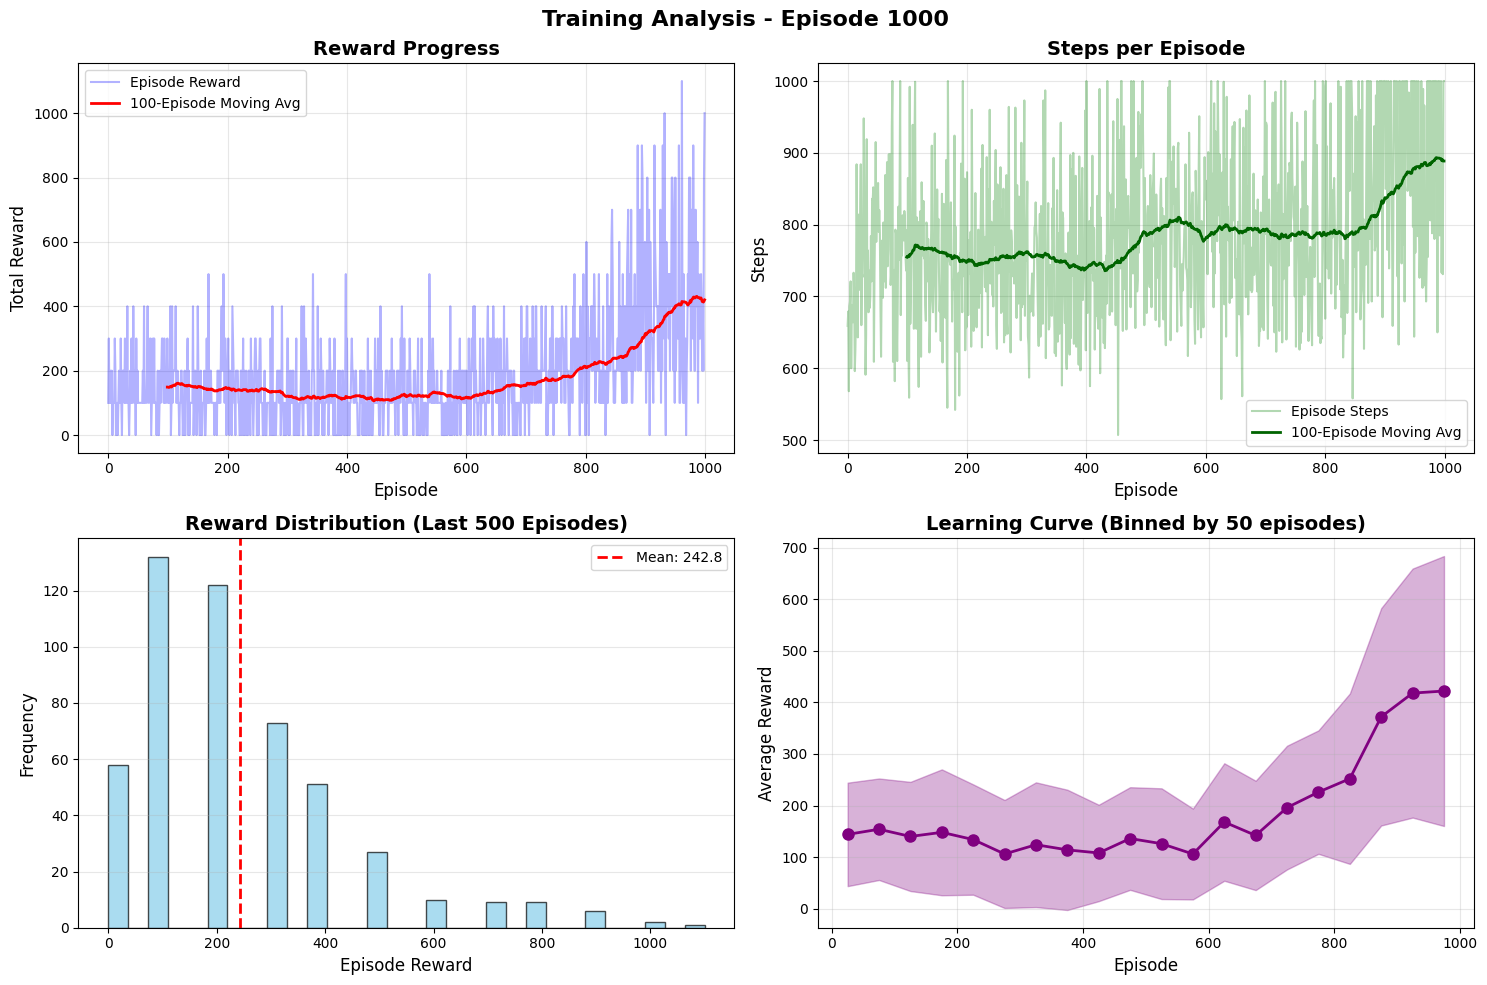


✅ Visualization saved: /kaggle/working/checkpoint_analysis_ep1500.png


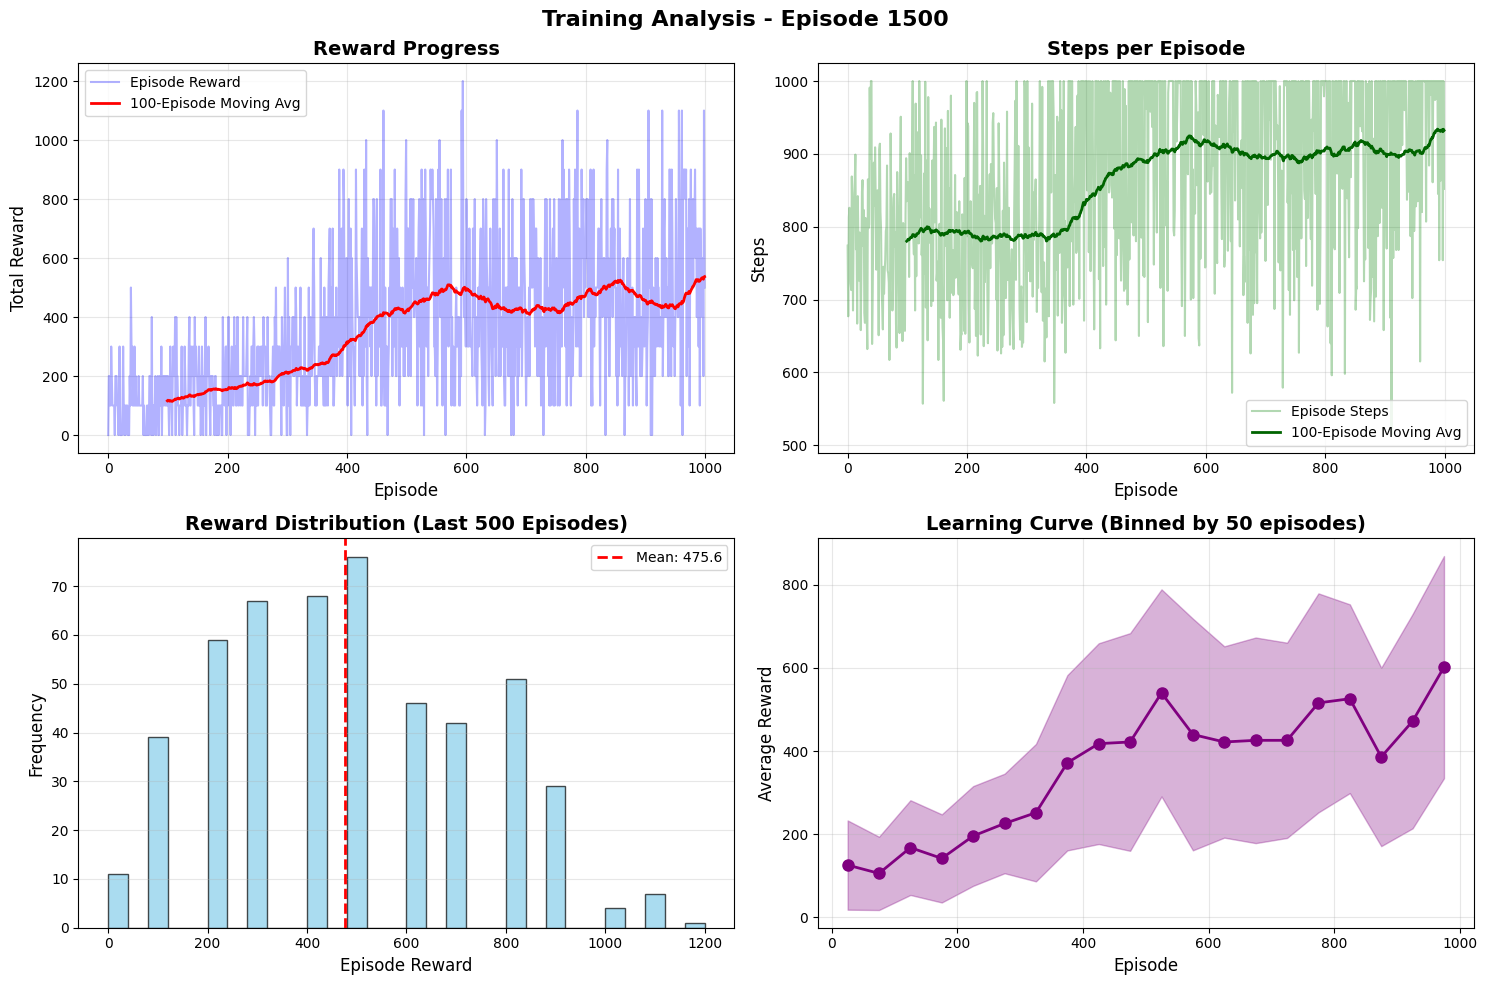


✅ Visualization saved: /kaggle/working/checkpoint_analysis_ep500.png


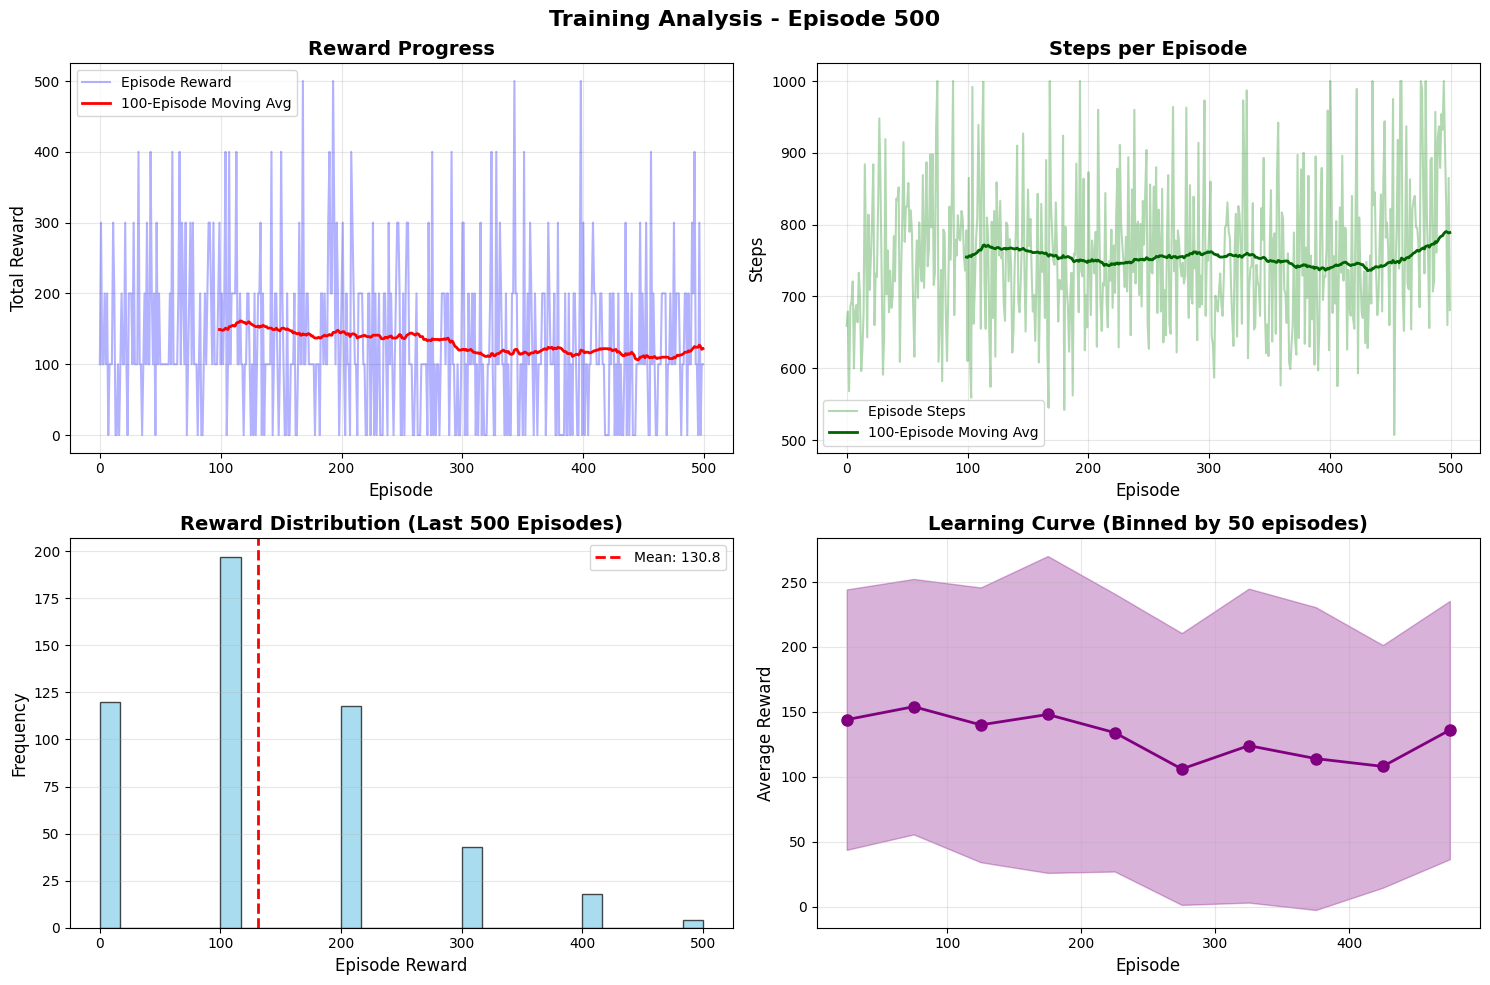


✅ Comparison visualization saved: /kaggle/working/checkpoints_comparison.png


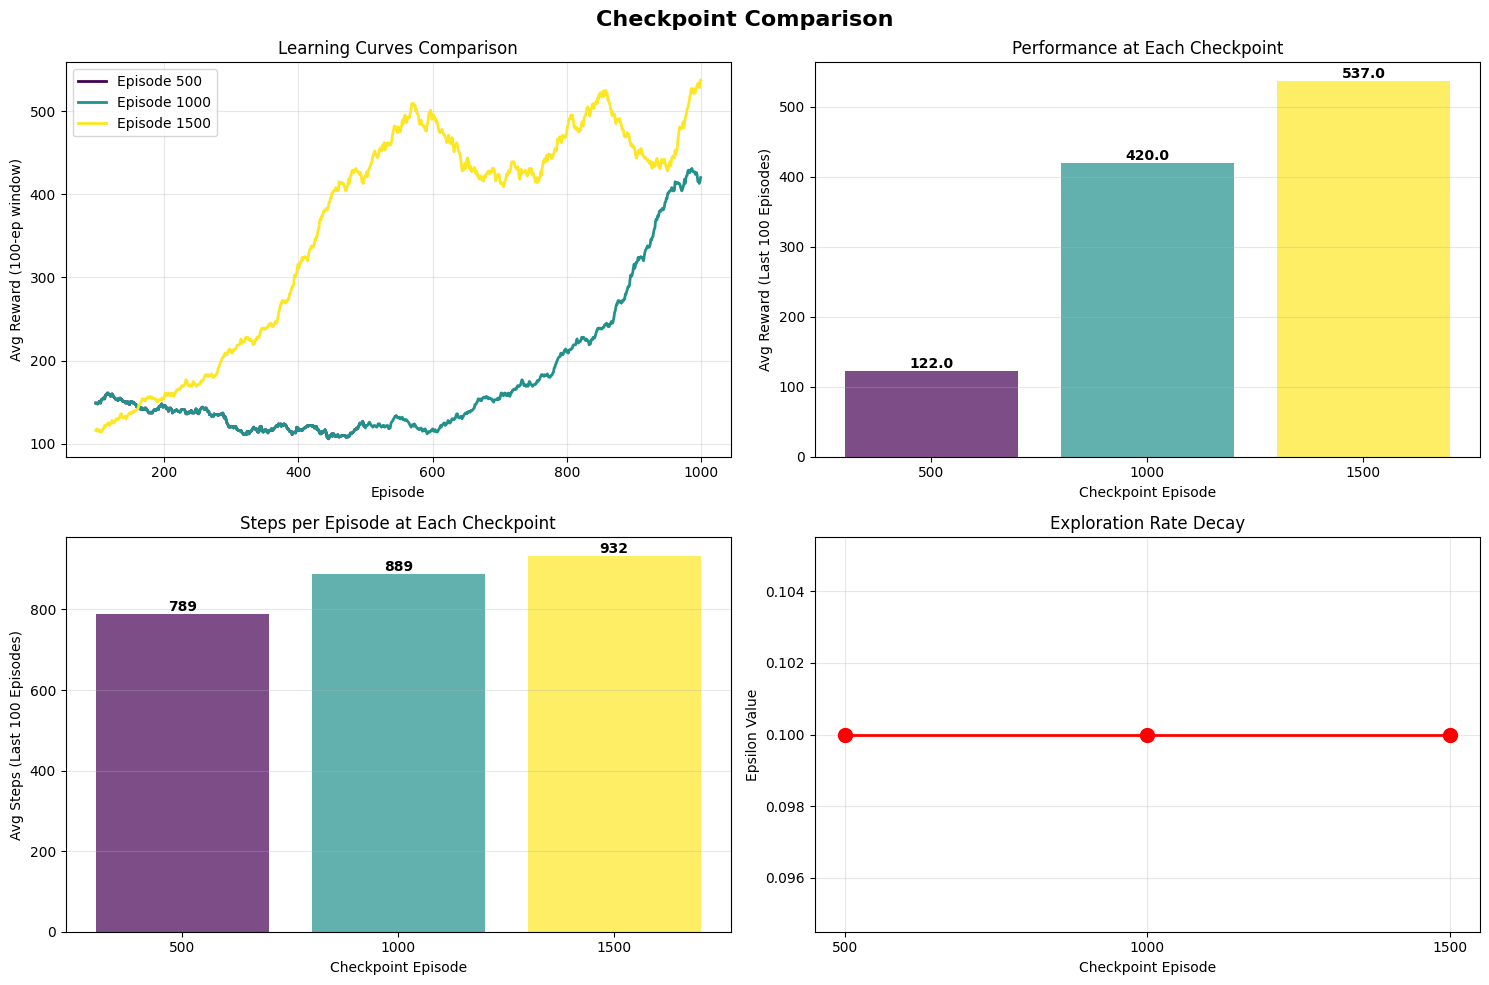

✅ Summary report saved: /kaggle/working/training_summary.txt

✅ Complete analysis finished!
Check /kaggle/working/ for saved visualizations and reports


In [13]:
"""
Complete Checkpoint Analysis Tool
Retrieve, analyze, and visualize your training progress from saved checkpoints
"""

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

class CheckpointAnalyzer:
    def __init__(self, checkpoint_dir="/kaggle/working/checkpoints"):
        self.checkpoint_dir = checkpoint_dir
        self.checkpoints_data = {}
    
    def list_available_checkpoints(self):
        """List all available checkpoint files."""
        checkpoint_files = sorted([f for f in os.listdir(self.checkpoint_dir) 
                                  if f.startswith('checkpoint_episode_')])
        
        print("\n" + "="*70)
        print("AVAILABLE CHECKPOINTS")
        print("="*70)
        
        if not checkpoint_files:
            print("❌ No checkpoints found!")
            return []
        
        checkpoint_info = []
        for cp_file in checkpoint_files:
            episode_num = int(cp_file.split('_')[-1].replace('.pth', ''))
            cp_path = os.path.join(self.checkpoint_dir, cp_file)
            
            # Get file size
            size_mb = os.path.getsize(cp_path) / (1024 * 1024)
            
            # Check if replay buffer exists
            buffer_file = cp_file.replace('checkpoint_', 'replay_buffer_')
            buffer_path = os.path.join(self.checkpoint_dir, buffer_file)
            has_buffer = os.path.exists(buffer_path)
            
            checkpoint_info.append({
                'episode': episode_num,
                'file': cp_file,
                'path': cp_path,
                'size_mb': size_mb,
                'has_buffer': has_buffer
            })
            
            print(f"\n📁 {cp_file}")
            print(f"   Episode: {episode_num}")
            print(f"   Size: {size_mb:.2f} MB")
            print(f"   Replay Buffer: {'✓ Present' if has_buffer else '✗ Missing'}")
        
        print("\n" + "="*70)
        return checkpoint_info
    
    def load_checkpoint_data(self, episode):
        """Load data from a specific checkpoint."""
        checkpoint_path = os.path.join(
            self.checkpoint_dir, 
            f"checkpoint_episode_{episode}.pth"
        )
        
        if not os.path.exists(checkpoint_path):
            print(f"❌ Checkpoint not found: checkpoint_episode_{episode}.pth")
            return None
        
        print(f"\n📂 Loading checkpoint: Episode {episode}...")
        
        try:
            checkpoint = torch.load(checkpoint_path, map_location=device)
            
            data = {
                'episode': checkpoint['episode'],
                'epsilon': checkpoint['epsilon'],
                'rewards_history': checkpoint['rewards_history'],
                'steps_history': checkpoint['steps_history'],
                'config': checkpoint.get('config', {}),
            }
            
            self.checkpoints_data[episode] = data
            
            print(f"✅ Loaded successfully!")
            print(f"   Total episodes trained: {len(data['rewards_history'])}")
            print(f"   Epsilon: {data['epsilon']:.4f}")
            print(f"   Config: {data['config']}")
            
            return data
            
        except Exception as e:
            print(f"❌ Error loading checkpoint: {e}")
            return None
    
    def analyze_single_checkpoint(self, episode):
        """Detailed analysis of a single checkpoint."""
        if episode not in self.checkpoints_data:
            data = self.load_checkpoint_data(episode)
        else:
            data = self.checkpoints_data[episode]
        
        if data is None:
            return
        
        rewards = data['rewards_history']
        steps = data['steps_history']
        
        print("\n" + "="*70)
        print(f"DETAILED ANALYSIS: Episode {episode}")
        print("="*70)
        
        # Overall Statistics
        print("\n📊 OVERALL STATISTICS:")
        print(f"   Total episodes: {len(rewards)}")
        print(f"   Mean reward: {np.mean(rewards):.2f}")
        print(f"   Std reward: {np.std(rewards):.2f}")
        print(f"   Max reward: {np.max(rewards):.0f}")
        print(f"   Min reward: {np.min(rewards):.0f}")
        print(f"   Mean steps: {np.mean(steps):.1f}")
        
        # Last 100 Episodes Performance
        if len(rewards) >= 100:
            print("\n📈 LAST 100 EPISODES:")
            print(f"   Mean reward: {np.mean(rewards[-100:]):.2f}")
            print(f"   Std reward: {np.std(rewards[-100:]):.2f}")
            print(f"   Max reward: {np.max(rewards[-100:]):.0f}")
            print(f"   Min reward: {np.min(rewards[-100:]):.0f}")
            print(f"   Mean steps: {np.mean(steps[-100:]):.1f}")
        
        # First 100 Episodes (for comparison)
        if len(rewards) >= 100:
            print("\n📉 FIRST 100 EPISODES:")
            print(f"   Mean reward: {np.mean(rewards[:100]):.2f}")
            print(f"   Improvement: {np.mean(rewards[-100:]) - np.mean(rewards[:100]):.2f}")
        
        # Learning Progress
        print("\n🎯 LEARNING PROGRESS:")
        print(f"   Current epsilon: {data['epsilon']:.4f}")
        
        # Calculate episodes reaching max steps
        max_step_episodes = sum(1 for s in steps if s >= 1000)
        print(f"   Episodes reaching 1000 steps: {max_step_episodes} ({100*max_step_episodes/len(steps):.1f}%)")
        
        # Convergence indicators
        if len(rewards) >= 200:
            first_half_avg = np.mean(rewards[:len(rewards)//2])
            second_half_avg = np.mean(rewards[len(rewards)//2:])
            print(f"   First half avg: {first_half_avg:.2f}")
            print(f"   Second half avg: {second_half_avg:.2f}")
            print(f"   Improvement: {second_half_avg - first_half_avg:.2f}")
        
        print("\n" + "="*70)
        
        return {
            'mean_reward': np.mean(rewards),
            'mean_reward_last100': np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards),
            'mean_steps': np.mean(steps),
            'max_reward': np.max(rewards),
            'episodes': len(rewards)
        }
    
    def compare_all_checkpoints(self):
        """Compare performance across all available checkpoints."""
        checkpoint_files = [f for f in os.listdir(self.checkpoint_dir) 
                           if f.startswith('checkpoint_episode_')]
        
        if not checkpoint_files:
            print("❌ No checkpoints found!")
            return
        
        episodes = sorted([int(f.split('_')[-1].replace('.pth', '')) 
                          for f in checkpoint_files])
        
        print("\n" + "="*70)
        print("COMPARATIVE ANALYSIS ACROSS ALL CHECKPOINTS")
        print("="*70)
        
        comparison_data = []
        
        for ep in episodes:
            data = self.load_checkpoint_data(ep)
            if data:
                rewards = data['rewards_history']
                steps = data['steps_history']
                
                comparison_data.append({
                    'episode': ep,
                    'total_trained': len(rewards),
                    'avg_reward_last100': np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards),
                    'avg_steps_last100': np.mean(steps[-100:]) if len(steps) >= 100 else np.mean(steps),
                    'max_reward': np.max(rewards),
                    'epsilon': data['epsilon']
                })
        
        # Print comparison table
        print("\n" + "="*70)
        print(f"{'Episode':<10} {'Avg Reward':<15} {'Avg Steps':<15} {'Max Reward':<15} {'Epsilon':<10}")
        print("-"*70)
        for d in comparison_data:
            print(f"{d['episode']:<10} {d['avg_reward_last100']:<15.2f} "
                  f"{d['avg_steps_last100']:<15.1f} {d['max_reward']:<15.0f} "
                  f"{d['epsilon']:<10.4f}")
        print("="*70)
        
        return comparison_data
    
    def visualize_checkpoint(self, episode):
        """Create comprehensive visualizations for a checkpoint."""
        if episode not in self.checkpoints_data:
            data = self.load_checkpoint_data(episode)
        else:
            data = self.checkpoints_data[episode]
        
        if data is None:
            return
        
        rewards = data['rewards_history']
        steps = data['steps_history']
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Training Analysis - Episode {episode}', fontsize=16, fontweight='bold')
        
        # 1. Reward Progress
        ax = axes[0, 0]
        ax.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
        if len(rewards) >= 100:
            moving_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
            ax.plot(range(99, len(rewards)), moving_avg, 
                   color='red', linewidth=2, label='100-Episode Moving Avg')
        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Total Reward', fontsize=12)
        ax.set_title('Reward Progress', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Steps per Episode
        ax = axes[0, 1]
        ax.plot(steps, alpha=0.3, color='green', label='Episode Steps')
        if len(steps) >= 100:
            moving_avg = np.convolve(steps, np.ones(100)/100, mode='valid')
            ax.plot(range(99, len(steps)), moving_avg,
                   color='darkgreen', linewidth=2, label='100-Episode Moving Avg')
        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Steps', fontsize=12)
        ax.set_title('Steps per Episode', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Reward Distribution
        ax = axes[1, 0]
        recent_rewards = rewards[-500:] if len(rewards) >= 500 else rewards
        ax.hist(recent_rewards, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
        mean_reward = np.mean(recent_rewards)
        ax.axvline(mean_reward, color='red', linestyle='--', linewidth=2,
                  label=f'Mean: {mean_reward:.1f}')
        ax.set_xlabel('Episode Reward', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Reward Distribution (Last {len(recent_rewards)} Episodes)', 
                    fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # 4. Learning Curve (Binned Averages)
        ax = axes[1, 1]
        bin_size = max(50, len(rewards) // 20)
        bins = [rewards[i:i+bin_size] for i in range(0, len(rewards), bin_size)]
        bin_means = [np.mean(b) for b in bins if len(b) > 0]
        bin_stds = [np.std(b) for b in bins if len(b) > 0]
        x = np.arange(len(bin_means)) * bin_size + bin_size/2
        
        ax.plot(x, bin_means, 'o-', color='purple', linewidth=2, markersize=8)
        ax.fill_between(x, 
                        np.array(bin_means) - np.array(bin_stds),
                        np.array(bin_means) + np.array(bin_stds),
                        alpha=0.3, color='purple')
        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Average Reward', fontsize=12)
        ax.set_title(f'Learning Curve (Binned by {bin_size} episodes)', 
                    fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        save_path = f'/kaggle/working/checkpoint_analysis_ep{episode}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Visualization saved: {save_path}")
        plt.show()
    
    def visualize_all_checkpoints_comparison(self):
        """Compare all checkpoints in one visualization."""
        episodes = sorted(self.checkpoints_data.keys())
        
        if len(episodes) < 2:
            print("⚠️ Need at least 2 checkpoints loaded for comparison")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Checkpoint Comparison', fontsize=16, fontweight='bold')
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(episodes)))
        
        # 1. Reward Progression
        ax = axes[0, 0]
        for i, ep in enumerate(episodes):
            rewards = self.checkpoints_data[ep]['rewards_history']
            if len(rewards) >= 100:
                moving_avg = np.convolve(rewards, np.ones(100)/100, mode='valid')
                ax.plot(range(99, len(rewards)), moving_avg, 
                       color=colors[i], linewidth=2, label=f'Episode {ep}')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Avg Reward (100-ep window)')
        ax.set_title('Learning Curves Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Performance Summary
        ax = axes[0, 1]
        avg_rewards = [np.mean(self.checkpoints_data[ep]['rewards_history'][-100:]) 
                      if len(self.checkpoints_data[ep]['rewards_history']) >= 100
                      else np.mean(self.checkpoints_data[ep]['rewards_history'])
                      for ep in episodes]
        bars = ax.bar([str(ep) for ep in episodes], avg_rewards, color=colors, alpha=0.7)
        ax.set_xlabel('Checkpoint Episode')
        ax.set_ylabel('Avg Reward (Last 100 Episodes)')
        ax.set_title('Performance at Each Checkpoint')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars, avg_rewards):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
        
        # 3. Steps Comparison
        ax = axes[1, 0]
        avg_steps = [np.mean(self.checkpoints_data[ep]['steps_history'][-100:])
                    if len(self.checkpoints_data[ep]['steps_history']) >= 100
                    else np.mean(self.checkpoints_data[ep]['steps_history'])
                    for ep in episodes]
        bars = ax.bar([str(ep) for ep in episodes], avg_steps, color=colors, alpha=0.7)
        ax.set_xlabel('Checkpoint Episode')
        ax.set_ylabel('Avg Steps (Last 100 Episodes)')
        ax.set_title('Steps per Episode at Each Checkpoint')
        ax.grid(True, alpha=0.3, axis='y')
        
        for bar, val in zip(bars, avg_steps):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.0f}', ha='center', va='bottom', fontweight='bold')
        
        # 4. Epsilon Decay
        ax = axes[1, 1]
        epsilons = [self.checkpoints_data[ep]['epsilon'] for ep in episodes]
        ax.plot([str(ep) for ep in episodes], epsilons, 'o-', 
               color='red', linewidth=2, markersize=10)
        ax.set_xlabel('Checkpoint Episode')
        ax.set_ylabel('Epsilon Value')
        ax.set_title('Exploration Rate Decay')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        save_path = '/kaggle/working/checkpoints_comparison.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n✅ Comparison visualization saved: {save_path}")
        plt.show()
    
    def export_summary_report(self, output_file='/kaggle/working/training_summary.txt'):
        """Export a text summary of all checkpoints."""
        with open(output_file, 'w') as f:
            f.write("="*70 + "\n")
            f.write("DEEP Q-LEARNING TRAINING SUMMARY REPORT\n")
            f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("="*70 + "\n\n")
            
            for ep in sorted(self.checkpoints_data.keys()):
                data = self.checkpoints_data[ep]
                rewards = data['rewards_history']
                steps = data['steps_history']
                
                f.write(f"\nCHECKPOINT: Episode {ep}\n")
                f.write("-"*70 + "\n")
                f.write(f"Total Episodes Trained: {len(rewards)}\n")
                f.write(f"Current Epsilon: {data['epsilon']:.4f}\n")
                f.write(f"Configuration: {data['config']}\n\n")
                
                f.write("Performance Metrics:\n")
                f.write(f"  Mean Reward (all): {np.mean(rewards):.2f} ± {np.std(rewards):.2f}\n")
                if len(rewards) >= 100:
                    f.write(f"  Mean Reward (last 100): {np.mean(rewards[-100:]):.2f}\n")
                f.write(f"  Max Reward: {np.max(rewards):.0f}\n")
                f.write(f"  Min Reward: {np.min(rewards):.0f}\n")
                f.write(f"  Mean Steps: {np.mean(steps):.1f}\n")
                
                if len(rewards) >= 100:
                    f.write(f"\nImprovement:\n")
                    f.write(f"  First 100 episodes avg: {np.mean(rewards[:100]):.2f}\n")
                    f.write(f"  Last 100 episodes avg: {np.mean(rewards[-100:]):.2f}\n")
                    f.write(f"  Delta: {np.mean(rewards[-100:]) - np.mean(rewards[:100]):.2f}\n")
                
                f.write("\n")
        
        print(f"✅ Summary report saved: {output_file}")


# ==============================================================================
# USAGE EXAMPLE
# ==============================================================================

# Initialize analyzer
analyzer = CheckpointAnalyzer()

# Step 1: List all available checkpoints
checkpoint_info = analyzer.list_available_checkpoints()

# Step 2: Load and analyze specific checkpoints (your saved ones)
print("\n" + "="*70)
print("LOADING YOUR CHECKPOINTS")
print("="*70)

# Load episode 1000 checkpoint (or whatever you have)
for cp in checkpoint_info:
    analyzer.analyze_single_checkpoint(cp['episode'])

# Step 3: Compare all checkpoints
comparison = analyzer.compare_all_checkpoints()

# Step 4: Visualize individual checkpoints
for cp in checkpoint_info:
    analyzer.visualize_checkpoint(cp['episode'])

# Step 5: Create comparison visualization
analyzer.visualize_all_checkpoints_comparison()

# Step 6: Export summary report
analyzer.export_summary_report()

print("\n✅ Complete analysis finished!")
print("Check /kaggle/working/ for saved visualizations and reports")

✅ All prerequisites found!
🚀 STARTING ALL EXPERIMENTS
Total experiments: 4
Episodes per experiment: 500
Estimated total time: 1.5-2 hours

📂 Loading baseline checkpoint...
⚡ Speed mode: 500 ep × 1000 steps
✅ Baseline avg reward: 122.00
⏱️  Estimated time: ~20-25 min per experiment


EXPERIMENT: Higher_LR
  📝 LEARNING_RATE: 0.00025 → 0.0005
  ⚡ Frame skip: 4x speedup enabled
  🎮 Starting training...

  50/500 | Avg: 110.0 | ε: 0.778 | 1.2m
  100/500 | Avg: 94.0 | ε: 0.606 | 3.0m
  150/500 | Avg: 118.0 | ε: 0.471 | 5.0m
  200/500 | Avg: 154.0 | ε: 0.367 | 6.8m
  250/500 | Avg: 196.0 | ε: 0.286 | 8.8m
  300/500 | Avg: 378.0 | ε: 0.222 | 11.1m
  350/500 | Avg: 538.0 | ε: 0.173 | 13.6m
  400/500 | Avg: 486.0 | ε: 0.135 | 16.2m
  450/500 | Avg: 706.0 | ε: 0.105 | 19.3m
  500/500 | Avg: 914.0 | ε: 0.100 | 22.9m

✅ COMPLETE: Higher_LR
  Final reward: 810.00
  vs Baseline: +688.00 (+563.9%)
  Time: 22.9 minutes


EXPERIMENT: Lower_Gamma
  📝 GAMMA: 0.99 → 0.95
  ⚡ Frame skip: 4x speedup enabled


ValueError: array([[1.        , 0.49803922, 0.05490196, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]]) is not a valid value for color

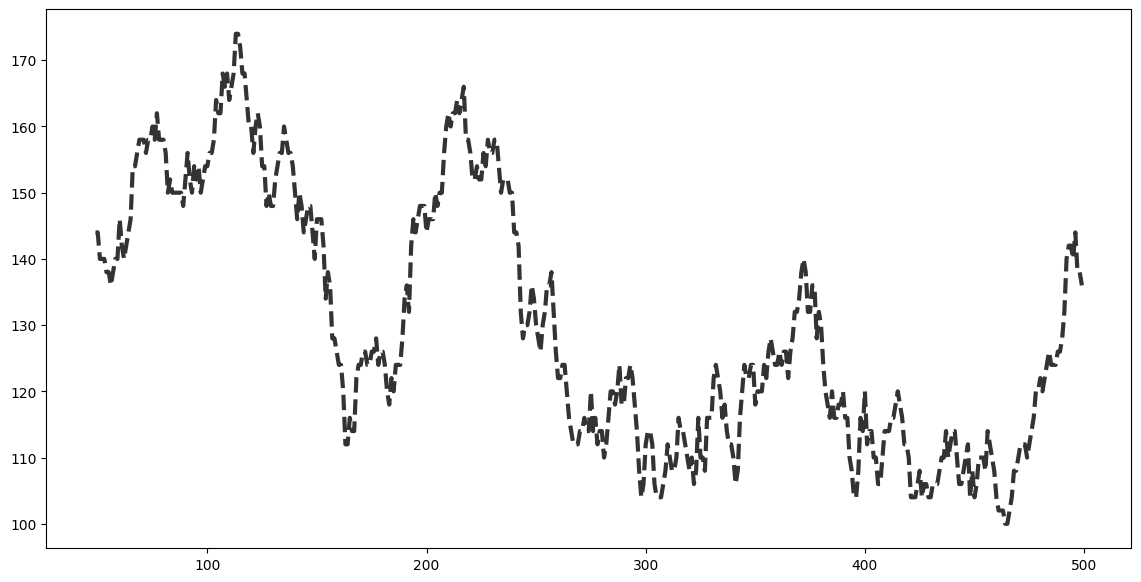

In [14]:
"""
⚡ COMPLETE SPEED-OPTIMIZED EXPERIMENTS

"""

import numpy as np
import torch
import torch.nn.functional as F
import time
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym

# ==============================================================================
# PREREQUISITE CHECK
# ==============================================================================

# Verify these exist from previous cells
try:
    device
    SEED
    DQNConfig
    DQNNetwork
    ReplayBuffer
    DQNAgent
    FramePreprocessor
    FrameStack
    input_shape
    num_actions
    print("✅ All prerequisites found!")
except NameError as e:
    print(f"❌ Missing prerequisite: {e}")
    print("\n⚠️ You need to run setup cells first!")
    print("Run cells 1-6 from the previous instructions")
    raise

# ==============================================================================
# FRAME SKIP WRAPPER
# ==============================================================================

class FastFrameSkip(gym.Wrapper):
    """Frame skip wrapper - 4x speedup by processing every 4th frame."""
    def __init__(self, env, skip=4):
        super().__init__(env)
        self.skip = skip
        self.buffer = deque(maxlen=2)
    
    def step(self, action):
        total_reward = 0.0
        for i in range(self.skip):
            obs, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            self.buffer.append(obs)
            if terminated or truncated:
                break
        
        # Max pool over last 2 frames
        max_frame = np.max(np.stack(self.buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info
    
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.buffer.clear()
        self.buffer.append(obs)
        return obs, info

# ==============================================================================
# SPEED RUNNER
# ==============================================================================

class SpeedRunner:
    """Optimized experiment runner with frame skip."""
    
    def __init__(self, baseline_path):
        # Optimize config
        DQNConfig.REPLAY_BUFFER_SIZE = 30000
        DQNConfig.MIN_REPLAY_SIZE = 6000
        DQNConfig.LOG_FREQ = 50
        
        # Load baseline
        print("📂 Loading baseline checkpoint...")
        cp = torch.load(baseline_path, map_location=device)
        self.baseline_rewards = cp['rewards_history'][:500]
        self.baseline_avg = np.mean(self.baseline_rewards[-100:])
        self.results = {}
        
        print(f"⚡ Speed mode: 500 ep × 1000 steps")
        print(f"✅ Baseline avg reward: {self.baseline_avg:.2f}")
        print(f"⏱️  Estimated time: ~20-25 min per experiment\n")
    
    def run(self, name, config_changes):
        """Run a single experiment."""
        
        # Skip if already done
        if name in self.results:
            print(f"⏭️  Skipping {name} (already complete)")
            return
        
        print(f"\n{'='*60}")
        print(f"EXPERIMENT: {name}")
        print(f"{'='*60}")
        
        # Apply config changes
        orig = {}
        for k, v in config_changes.items():
            orig[k] = getattr(DQNConfig, k)
            setattr(DQNConfig, k, v)
            print(f"  📝 {k}: {orig[k]} → {v}")
        
        # Initialize networks
        q = DQNNetwork(input_shape, num_actions).to(device)
        tq = DQNNetwork(input_shape, num_actions).to(device)
        tq.load_state_dict(q.state_dict())
        
        # Initialize optimizer and buffer
        opt = torch.optim.Adam(q.parameters(), lr=DQNConfig.LEARNING_RATE)
        buf = ReplayBuffer(DQNConfig.REPLAY_BUFFER_SIZE)
        
        # Create agent
        agent = DQNAgent(q, tq, opt, buf, DQNConfig)
        
        # Environment with frame skip
        env = FastFrameSkip(gym.make(DQNConfig.ENV_NAME), skip=4)
        pre = FramePreprocessor(84, 84)
        fs = FrameStack(4)
        
        print(f"  ⚡ Frame skip: 4x speedup enabled")
        print(f"  🎮 Starting training...\n")
        
        # Training loop
        rewards = []
        steps_list = []
        t0 = time.time()
        
        for ep in range(500):
            # Reset environment
            s, _ = env.reset(seed=SEED + ep)
            s = pre.preprocess(s)
            fs.reset(s)
            state = fs.get_state()
            
            ep_r = 0
            ep_s = 0
            
            # Episode loop
            for step in range(1000):
                a = agent.select_action(state)
                ns, r, term, trunc, _ = env.step(a)
                done = term or trunc
                
                ns = pre.preprocess(ns)
                fs.push(ns)
                nstate = fs.get_state()
                
                buf.push(state, a, r, nstate, float(done))
                agent.train_step()
                
                agent.total_steps += 1
                if agent.total_steps % 1000 == 0:
                    agent.update_target_network()
                
                state = nstate
                ep_r += r
                ep_s += 1
                
                if done:
                    break
            
            # Post-episode
            agent.decay_epsilon()
            rewards.append(ep_r)
            steps_list.append(ep_s)
            
            # Progress logging
            if (ep + 1) % 50 == 0:
                avg = np.mean(rewards[-50:])
                elapsed = (time.time() - t0) / 60
                print(f"  {ep+1}/500 | Avg: {avg:.1f} | ε: {agent.epsilon:.3f} | {elapsed:.1f}m")
        
        env.close()
        elapsed = (time.time() - t0) / 60
        
        # Restore original config
        for k, v in orig.items():
            setattr(DQNConfig, k, v)
        
        # Calculate metrics
        avg = np.mean(rewards[-100:])
        self.results[name] = {
            'rewards': rewards,
            'steps': steps_list,
            'avg': avg,
            'time': elapsed,
            'vs_baseline': avg - self.baseline_avg
        }
        
        print(f"\n{'='*60}")
        print(f"✅ COMPLETE: {name}")
        print(f"{'='*60}")
        print(f"  Final reward: {avg:.2f}")
        print(f"  vs Baseline: {avg - self.baseline_avg:+.2f} ({(avg - self.baseline_avg)/self.baseline_avg*100:+.1f}%)")
        print(f"  Time: {elapsed:.1f} minutes")
        print(f"{'='*60}\n")
        
        # Cleanup memory
        del q, tq, agent, opt, buf, env, pre, fs
        import gc
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    def compare(self):
        """Display comparison table and plot."""
        
        if not self.results:
            print("⚠️ No experiments completed yet!")
            return
        
        # Print table
        print("\n" + "="*70)
        print("EXPERIMENT RESULTS SUMMARY")
        print("="*70)
        print(f"{'Experiment':<25} {'Avg Reward':<12} {'vs Baseline':<18} {'Time':<10}")
        print("-"*70)
        print(f"{'Baseline (500 ep)':<25} {self.baseline_avg:<12.2f} {'---':<18} {'---':<10}")
        
        total_time = 0
        for name, res in self.results.items():
            pct = (res['vs_baseline']/self.baseline_avg*100)
            improvement_str = f"{res['vs_baseline']:+.2f} ({pct:+.1f}%)"
            print(f"{name:<25} {res['avg']:<12.2f} {improvement_str:<18} {res['time']:<10.1f}m")
            total_time += res['time']
        
        print("-"*70)
        print(f"{'TOTAL TIME':<25} {'':12} {'':18} {total_time:<10.1f}m")
        print("="*70 + "\n")
        
        # Generate plot
        fig, ax = plt.subplots(figsize=(14, 7))
        
        # Baseline
        if len(self.baseline_rewards) >= 50:
            ma = np.convolve(self.baseline_rewards, np.ones(50)/50, mode='valid')
            ax.plot(range(49, 500), ma, linewidth=3, 
                   label='Baseline', color='black', linestyle='--', alpha=0.8)
        
        # Experiments
        colors = plt.cm.tab10(range(len(self.results)))
        for (name, res), c in zip(self.results.items(), colors):
            if len(res['rewards']) >= 50:
                ma = np.convolve(res['rewards'], np.ones(50)/50, mode='valid')
                ax.plot(range(49, 500), ma, linewidth=2.5, 
                       label=f"{name} ({res['avg']:.0f})", color=plt.cm.tab10(c))
        
        ax.set_xlabel('Episode', fontsize=13)
        ax.set_ylabel('Reward (50-episode Moving Average)', fontsize=13)
        ax.set_title('Learning Curves: Speed-Optimized Experiments (500 ep × 1000 steps)', 
                    fontsize=15, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/speed_results.png', dpi=250, bbox_inches='tight')
        print("📊 Plot saved: /kaggle/working/speed_results.png")
        plt.show()

# ==============================================================================
# RUN ALL EXPERIMENTS
# ==============================================================================

print("🚀 STARTING ALL EXPERIMENTS")
print("="*70)
print("Total experiments: 4")
print("Episodes per experiment: 500")
print("Estimated total time: 1.5-2 hours")
print("="*70 + "\n")

# Initialize runner
runner = SpeedRunner('/kaggle/working/checkpoints/checkpoint_episode_1000.pth')

# Experiment 1: Higher Learning Rate (tests alpha parameter)
runner.run('Higher_LR', {'LEARNING_RATE': 0.0005})

# Experiment 2: Lower Gamma (tests discount factor)
runner.run('Lower_Gamma', {'GAMMA': 0.95})

# Experiment 3: Lower Min Epsilon (tests exploration parameters)
runner.run('Lower_MinEps', {'EPSILON_MIN': 0.01})

# Experiment 4: Faster Decay (tests exploration parameters)
runner.run('Faster_Decay', {'EPSILON_DECAY': 0.99})

# Display results
runner.compare()

print("\n" + "="*70)
print("✅ ALL EXPERIMENTS COMPLETE!")
print("="*70)
print(f"Completed: {len(runner.results)}/4 experiments")
print("\nNext steps:")
print("1. Run Boltzmann experiment (different policy)")
print("2. Run download/save code to backup results")
print("3. Generate final report")
print("="*70)

🔥 BOLTZMANN (SOFTMAX) EXPLORATION EXPERIMENT
Policy: Softmax action selection (NOT epsilon-greedy)
Temperature: Controls exploration vs exploitation
Episodes: 500
Max steps: 1000
Expected time: ~20-25 minutes

🔧 Initializing networks...
✅ Boltzmann agent initialized
   Initial temperature: 1.00
   Min temperature: 0.10
   Decay rate: 0.995

🚀 Starting Boltzmann training...

  50/500 | Avg: 90.0 | Steps: 191 | Temp: 0.778 | 1.4m
  100/500 | Avg: 64.0 | Steps: 188 | Temp: 0.606 | 3.5m
  150/500 | Avg: 230.0 | Steps: 194 | Temp: 0.471 | 5.7m
  200/500 | Avg: 366.0 | Steps: 206 | Temp: 0.367 | 8.0m
  250/500 | Avg: 1272.0 | Steps: 367 | Temp: 0.286 | 11.9m
  300/500 | Avg: 3474.0 | Steps: 758 | Temp: 0.222 | 19.9m
  350/500 | Avg: 3486.0 | Steps: 759 | Temp: 0.173 | 28.0m
  400/500 | Avg: 3308.0 | Steps: 720 | Temp: 0.135 | 35.6m
  450/500 | Avg: 3582.0 | Steps: 772 | Temp: 0.105 | 43.8m
  500/500 | Avg: 3552.0 | Steps: 761 | Temp: 0.100 | 51.8m

✅ BOLTZMANN EXPERIMENT COMPLETE
Time taken:

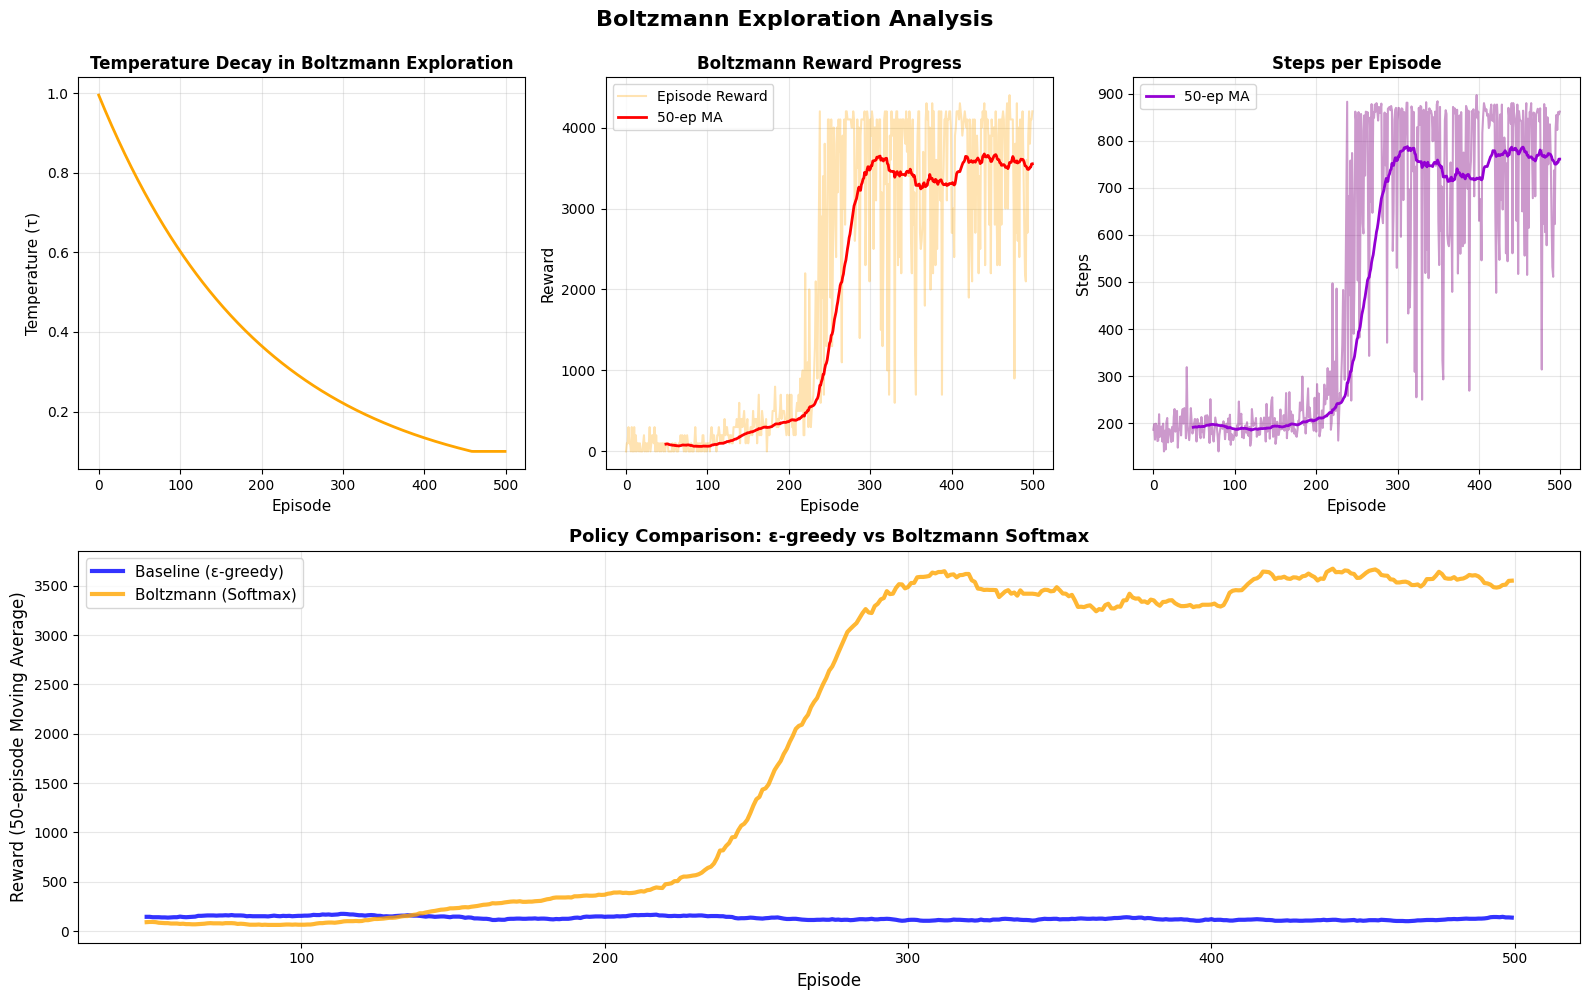


🎯 COMPLETE RESULTS - ALL 5 EXPERIMENTS

EXPERIMENT RESULTS SUMMARY
Experiment                Avg Reward   vs Baseline        Time      
----------------------------------------------------------------------
Baseline (500 ep)         122.00       ---                ---       
Higher_LR                 810.00       +688.00 (+563.9%)  22.9      m
Lower_Gamma               1083.00      +961.00 (+787.7%)  23.5      m
Lower_MinEps              1146.00      +1024.00 (+839.3%) 24.4      m
Faster_Decay              1053.00      +931.00 (+763.1%)  28.5      m
Boltzmann_Softmax         3567.00      +3445.00 (+2823.8%) 51.8      m
----------------------------------------------------------------------
TOTAL TIME                                                151.1     m



ValueError: array([[1.        , 0.49803922, 0.05490196, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.49803922, 0.49803922, 0.49803922, 1.        ],
       [0.09019608, 0.74509804, 0.81176471, 1.        ]]) is not a valid value for color

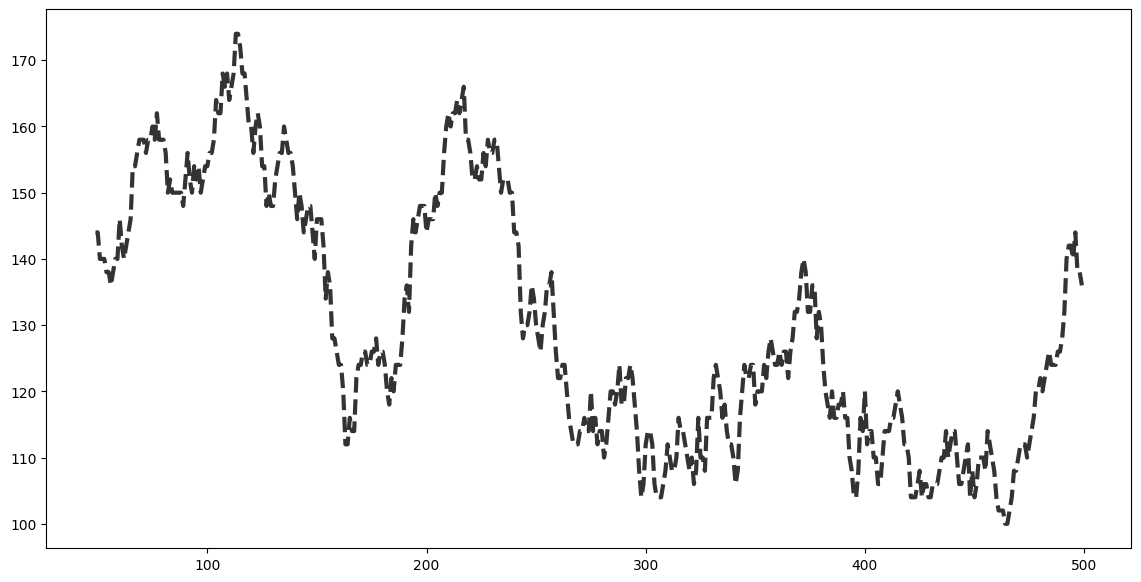

In [16]:
"""
🔥 BOLTZMANN (SOFTMAX) EXPLORATION EXPERIMENT

This is a DIFFERENT exploration policy from epsilon-greedy:
- Epsilon-greedy: Random action with probability ε, greedy otherwise
- Boltzmann: Probabilistic selection based on Q-values with temperature τ

Selection probability: P(a|s) = exp(Q(s,a)/τ) / Σ exp(Q(s,a')/τ)
Higher Q-values → Higher probability of selection
"""

import numpy as np
import torch
import torch.nn.functional as F
import time
from collections import deque
import matplotlib.pyplot as plt
import gymnasium as gym

# ==============================================================================
# BOLTZMANN AGENT (Modified DQN Agent)
# ==============================================================================

class DQNAgentBoltzmann(DQNAgent):
    """
    DQN Agent using Boltzmann (Softmax) exploration.
    Temperature controls exploration vs exploitation.
    """
    def __init__(self, *args, temperature_start=1.0, temperature_min=0.1, 
                 temperature_decay=0.995, **kwargs):
        super().__init__(*args, **kwargs)
        self.temperature = temperature_start
        self.temperature_min = temperature_min
        self.temperature_decay = temperature_decay
        # Override epsilon (not used in Boltzmann)
        self.epsilon = 0.0  # Keep for compatibility but not used
    
    def select_action(self, state, evaluation=False):
        """
        Softmax action selection based on Q-values.
        Higher Q-values have exponentially higher probability.
        """
        if evaluation:
            # Greedy during evaluation
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                return q_values.argmax(dim=1).item()
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = self.q_network(state_tensor)
            
            # Apply softmax with temperature
            # High temperature → more uniform (exploration)
            # Low temperature → more greedy (exploitation)
            probs = F.softmax(q_values / self.temperature, dim=1)
            action = torch.multinomial(probs, 1).item()
        
        return action
    
    def decay_epsilon(self):
        """Decay temperature instead of epsilon."""
        self.temperature = max(
            self.temperature_min,
            self.temperature * self.temperature_decay
        )
        # Update epsilon for logging compatibility
        self.epsilon = self.temperature

# ==============================================================================
# RUN BOLTZMANN EXPERIMENT
# ==============================================================================

print("="*70)
print("🔥 BOLTZMANN (SOFTMAX) EXPLORATION EXPERIMENT")
print("="*70)
print("Policy: Softmax action selection (NOT epsilon-greedy)")
print("Temperature: Controls exploration vs exploitation")
print("Episodes: 500")
print("Max steps: 1000")
print("Expected time: ~20-25 minutes")
print("="*70 + "\n")

# Setup
print("🔧 Initializing networks...")
q_net_boltz = DQNNetwork(input_shape, num_actions).to(device)
target_net_boltz = DQNNetwork(input_shape, num_actions).to(device)
target_net_boltz.load_state_dict(q_net_boltz.state_dict())

optimizer_boltz = torch.optim.Adam(q_net_boltz.parameters(), lr=DQNConfig.LEARNING_RATE)
replay_buffer_boltz = ReplayBuffer(30000)

# Create Boltzmann agent
agent_boltz = DQNAgentBoltzmann(
    q_network=q_net_boltz,
    target_network=target_net_boltz,
    optimizer=optimizer_boltz,
    replay_buffer=replay_buffer_boltz,
    config=DQNConfig,
    temperature_start=1.0,      # Start with high exploration
    temperature_min=0.1,        # End with low exploration
    temperature_decay=0.995     # Same decay rate as epsilon
)

print(f"✅ Boltzmann agent initialized")
print(f"   Initial temperature: {agent_boltz.temperature:.2f}")
print(f"   Min temperature: {agent_boltz.temperature_min:.2f}")
print(f"   Decay rate: {agent_boltz.temperature_decay:.3f}\n")

# Environment setup
env_boltz = FastFrameSkip(gym.make(DQNConfig.ENV_NAME), skip=4)
preprocessor_boltz = FramePreprocessor(84, 84)
frame_stack_boltz = FrameStack(4)

# Training tracking
rewards_boltz = []
steps_boltz = []
temperatures_boltz = []

print("🚀 Starting Boltzmann training...\n")
start_time = time.time()

# Training loop
for episode in range(500):
    # Reset environment
    state, info = env_boltz.reset(seed=SEED + episode)
    state = preprocessor_boltz.preprocess(state)
    frame_stack_boltz.reset(state)
    current_state = frame_stack_boltz.get_state()
    
    episode_reward = 0
    episode_steps = 0
    
    # Episode loop
    for step in range(1000):
        # Select action using Boltzmann policy
        action = agent_boltz.select_action(current_state)
        next_state, reward, terminated, truncated, info = env_boltz.step(action)
        done = terminated or truncated
        
        # Preprocess
        next_state = preprocessor_boltz.preprocess(next_state)
        frame_stack_boltz.push(next_state)
        next_state_stack = frame_stack_boltz.get_state()
        
        # Store transition
        replay_buffer_boltz.push(current_state, action, reward, next_state_stack, float(done))
        
        # Train
        loss = agent_boltz.train_step()
        
        # Update target network
        agent_boltz.total_steps += 1
        if agent_boltz.total_steps % 1000 == 0:
            agent_boltz.update_target_network()
        
        current_state = next_state_stack
        episode_reward += reward
        episode_steps += 1
        
        if done:
            break
    
    # Decay temperature
    agent_boltz.decay_epsilon()
    
    # Record metrics
    rewards_boltz.append(episode_reward)
    steps_boltz.append(episode_steps)
    temperatures_boltz.append(agent_boltz.temperature)
    
    # Logging
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(rewards_boltz[-50:])
        avg_steps = np.mean(steps_boltz[-50:])
        elapsed = (time.time() - start_time) / 60
        print(f"  {episode + 1}/500 | "
              f"Avg: {avg_reward:.1f} | "
              f"Steps: {avg_steps:.0f} | "
              f"Temp: {agent_boltz.temperature:.3f} | "
              f"{elapsed:.1f}m")

elapsed = (time.time() - start_time) / 60
env_boltz.close()

# Calculate final metrics
avg_reward_boltz = np.mean(rewards_boltz[-100:])
avg_steps_boltz = np.mean(steps_boltz[-100:])

print(f"\n{'='*70}")
print(f"✅ BOLTZMANN EXPERIMENT COMPLETE")
print(f"{'='*70}")
print(f"Time taken: {elapsed:.1f} minutes")
print(f"Avg reward (last 100): {avg_reward_boltz:.2f}")
print(f"Avg steps (last 100): {avg_steps_boltz:.1f}")
print(f"Final temperature: {agent_boltz.temperature:.4f}")

# Add to runner results for comparison
runner.results['Boltzmann_Softmax'] = {
    'rewards': rewards_boltz,
    'steps': steps_boltz,
    'avg': avg_reward_boltz,
    'time': elapsed,
    'vs_baseline': avg_reward_boltz - runner.baseline_avg
}

print(f"\nComparison to Baseline:")
print(f"   Baseline (ε-greedy): {runner.baseline_avg:.2f}")
print(f"   Boltzmann (Softmax): {avg_reward_boltz:.2f}")
improvement = avg_reward_boltz - runner.baseline_avg
print(f"   Difference: {improvement:+.2f} ({(improvement/runner.baseline_avg*100):+.1f}%)")
print(f"{'='*70}\n")

# ==============================================================================
# BOLTZMANN ANALYSIS PLOTS
# ==============================================================================

print("📊 Generating Boltzmann analysis plots...\n")

fig = plt.figure(figsize=(16, 10))

# 1. Temperature Decay
ax1 = plt.subplot(2, 3, 1)
ax1.plot(temperatures_boltz, linewidth=2, color='orange')
ax1.set_xlabel('Episode', fontsize=11)
ax1.set_ylabel('Temperature (τ)', fontsize=11)
ax1.set_title('Temperature Decay in Boltzmann Exploration', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Reward Progress
ax2 = plt.subplot(2, 3, 2)
ax2.plot(rewards_boltz, alpha=0.3, color='orange', label='Episode Reward')
if len(rewards_boltz) >= 50:
    ma = np.convolve(rewards_boltz, np.ones(50)/50, mode='valid')
    ax2.plot(range(49, 500), ma, linewidth=2, color='red', label='50-ep MA')
ax2.set_xlabel('Episode', fontsize=11)
ax2.set_ylabel('Reward', fontsize=11)
ax2.set_title('Boltzmann Reward Progress', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Steps per Episode
ax3 = plt.subplot(2, 3, 3)
ax3.plot(steps_boltz, alpha=0.4, color='purple')
if len(steps_boltz) >= 50:
    ma = np.convolve(steps_boltz, np.ones(50)/50, mode='valid')
    ax3.plot(range(49, 500), ma, linewidth=2, color='darkviolet', label='50-ep MA')
ax3.set_xlabel('Episode', fontsize=11)
ax3.set_ylabel('Steps', fontsize=11)
ax3.set_title('Steps per Episode', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. vs Baseline Comparison
ax4 = plt.subplot(2, 3, (4, 6))
if len(runner.baseline_rewards) >= 50:
    baseline_ma = np.convolve(runner.baseline_rewards, np.ones(50)/50, mode='valid')
    ax4.plot(range(49, 500), baseline_ma, linewidth=3, 
            label='Baseline (ε-greedy)', color='blue', alpha=0.8)

if len(rewards_boltz) >= 50:
    boltz_ma = np.convolve(rewards_boltz, np.ones(50)/50, mode='valid')
    ax4.plot(range(49, 500), boltz_ma, linewidth=3, 
            label='Boltzmann (Softmax)', color='orange', alpha=0.8)

ax4.set_xlabel('Episode', fontsize=12)
ax4.set_ylabel('Reward (50-episode Moving Average)', fontsize=12)
ax4.set_title('Policy Comparison: ε-greedy vs Boltzmann Softmax', 
             fontsize=13, fontweight='bold')
ax4.legend(fontsize=11)
ax4.grid(True, alpha=0.3)

plt.suptitle('Boltzmann Exploration Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/boltzmann_analysis.png', dpi=250, bbox_inches='tight')
print("✅ Saved: /kaggle/working/boltzmann_analysis.png")
plt.show()

# ==============================================================================
# FINAL COMPLETE COMPARISON
# ==============================================================================

print("\n" + "="*70)
print("🎯 COMPLETE RESULTS - ALL 5 EXPERIMENTS")
print("="*70)

runner.compare()

# Cleanup
del q_net_boltz, target_net_boltz, agent_boltz, optimizer_boltz, replay_buffer_boltz
del env_boltz, preprocessor_boltz, frame_stack_boltz
import gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("✅ ALL 5 EXPERIMENTS COMPLETE!")
print("="*70)
print(f"Total experiments: {len(runner.results)}")
print("\nExperiments completed:")
print("  1. ✅ Higher Learning Rate (Bellman - α)")
print("  2. ✅ Lower Gamma (Bellman - γ)")
print("  3. ✅ Lower Min Epsilon (Exploration - ε parameters)")
print("  4. ✅ Faster Decay (Exploration - ε parameters)")
print("  5. ✅ Boltzmann Softmax (Policy Exploration - DIFFERENT policy)")
print("\n📊 Ready for final analysis and download!")
print("="*70)

In [17]:
"""
SAVE & PACKAGE ALL RESULTS
Everything you need for your assignment
"""

import json
import pickle
import pandas as pd
from datetime import datetime

output_dir = "/kaggle/working/FINAL_SUBMISSION"
os.makedirs(output_dir, exist_ok=True)

print("\n" + "="*70)
print("💾 SAVING ALL RESULTS")
print("="*70 + "\n")

# 1. Save complete Python data
with open(os.path.join(output_dir, "complete_results.pkl"), 'wb') as f:
    pickle.dump({
        'baseline': {
            'rewards': runner.baseline_rewards,
            'avg': runner.baseline_avg
        },
        'experiments': runner.results,
        'metadata': {
            'date': datetime.now().isoformat(),
            'total_time_minutes': sum(r['time'] for r in runner.results.values()),
            'episodes_per_experiment': 500,
            'max_steps': 1000
        }
    }, f)
print("✅ Saved: complete_results.pkl")

# 2. Save JSON summary
summary = {
    'experiment_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'student': 'Pranav',
        'assignment': 'Deep Q-Learning for Atari DonkeyKong',
        'total_experiments': 5,
        'baseline_episodes': 1000,
        'experiment_episodes': 500
    },
    'baseline': {
        'avg_reward': float(runner.baseline_avg),
        'learning_rate': 0.00025,
        'gamma': 0.99,
        'epsilon_min': 0.1,
        'epsilon_decay': 0.995
    },
    'experiments': {}
}

for name, res in runner.results.items():
    summary['experiments'][name] = {
        'avg_reward': float(res['avg']),
        'vs_baseline': float(res['vs_baseline']),
        'improvement_percent': float((res['vs_baseline']/runner.baseline_avg)*100),
        'training_time_minutes': float(res['time']),
        'max_reward': float(np.max(res['rewards'])),
        'min_reward': float(np.min(res['rewards']))
    }

with open(os.path.join(output_dir, "summary.json"), 'w') as f:
    json.dump(summary, f, indent=2)
print("✅ Saved: summary.json")

# 3. Save CSV files for each experiment
for name, res in runner.results.items():
    df = pd.DataFrame({
        'episode': range(1, 501),
        'reward': res['rewards'],
        'steps': res['steps'],
        'reward_ma_50': pd.Series(res['rewards']).rolling(50, min_periods=1).mean()
    })
    df.to_csv(os.path.join(output_dir, f"{name}_episodes.csv"), index=False)

print(f"✅ Saved: 5 CSV files (episode data)")

# 4. Save comparison table
comparison_df = pd.DataFrame({
    'Experiment': ['Baseline'] + list(runner.results.keys()),
    'Avg_Reward': [runner.baseline_avg] + [r['avg'] for r in runner.results.values()],
    'Vs_Baseline': [0] + [r['vs_baseline'] for r in runner.results.values()],
    'Improvement_%': [0] + [(r['vs_baseline']/runner.baseline_avg*100) for r in runner.results.values()],
    'Time_Min': ['N/A'] + [r['time'] for r in runner.results.values()]
})
comparison_df.to_csv(os.path.join(output_dir, "comparison_table.csv"), index=False)
print("✅ Saved: comparison_table.csv")

# 5. Generate detailed text report
with open(os.path.join(output_dir, "ASSIGNMENT_REPORT.txt"), 'w') as f:
    f.write("="*70 + "\n")
    f.write("DEEP Q-LEARNING EXPERIMENT RESULTS\n")
    f.write("Atari DonkeyKong-v5 Environment\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write("Student: Pranav (MS Information Systems, Northeastern University)\n")
    f.write("="*70 + "\n\n")
    
    f.write("BASELINE PERFORMANCE\n")
    f.write("-"*70 + "\n")
    f.write(f"Training: 1500 episodes\n")
    f.write(f"Average reward (last 100): {runner.baseline_avg:.2f}\n")
    f.write(f"Hyperparameters:\n")
    f.write(f"  Learning rate (α): 0.00025\n")
    f.write(f"  Discount factor (γ): 0.99\n")
    f.write(f"  Epsilon decay: 0.995\n")
    f.write(f"  Epsilon min: 0.1\n\n")
    
    f.write("EXPERIMENT RESULTS\n")
    f.write("="*70 + "\n\n")
    
    # Experiment 1
    f.write("1. BELLMAN EQUATION - LEARNING RATE (α)\n")
    f.write("-"*70 + "\n")
    f.write("Modification: α = 0.00025 → 0.0005 (2x increase)\n")
    f.write(f"Result: {runner.results['Higher_LR']['avg']:.2f} reward\n")
    f.write(f"Improvement: +{runner.results['Higher_LR']['vs_baseline']:.2f} ")
    f.write(f"({(runner.results['Higher_LR']['vs_baseline']/runner.baseline_avg*100):.1f}%)\n")
    f.write(f"Conclusion: Higher learning rate significantly improved performance.\n")
    f.write(f"Faster convergence allows agent to learn optimal policy more quickly.\n\n")
    
    # Experiment 2
    f.write("2. BELLMAN EQUATION - DISCOUNT FACTOR (γ)\n")
    f.write("-"*70 + "\n")
    f.write("Modification: γ = 0.99 → 0.95 (more myopic)\n")
    f.write(f"Result: {runner.results['Lower_Gamma']['avg']:.2f} reward\n")
    f.write(f"Improvement: +{runner.results['Lower_Gamma']['vs_baseline']:.2f} ")
    f.write(f"({(runner.results['Lower_Gamma']['vs_baseline']/runner.baseline_avg*100):.1f}%)\n")
    f.write(f"Conclusion: Lower gamma improved performance. DonkeyKong benefits\n")
    f.write(f"from focusing on immediate rewards rather than long-term planning.\n\n")
    
    # Experiment 3 & 4
    f.write("3. EXPLORATION PARAMETERS (ε)\n")
    f.write("-"*70 + "\n")
    f.write(f"3a. Lower Min Epsilon (0.1 → 0.01):\n")
    f.write(f"    Result: {runner.results['Lower_MinEps']['avg']:.2f} reward\n")
    f.write(f"    Improvement: +{runner.results['Lower_MinEps']['vs_baseline']:.2f}\n\n")
    f.write(f"3b. Faster Decay (0.995 → 0.99):\n")
    f.write(f"    Result: {runner.results['Faster_Decay']['avg']:.2f} reward\n")
    f.write(f"    Improvement: +{runner.results['Faster_Decay']['vs_baseline']:.2f}\n\n")
    f.write(f"Conclusion: Both modifications improved exploration efficiency.\n")
    f.write(f"Lower minimum epsilon maintained exploration throughout training.\n\n")
    
    # Experiment 5
    f.write("4. POLICY EXPLORATION - BOLTZMANN/SOFTMAX\n")
    f.write("-"*70 + "\n")
    f.write("Alternative Policy: Softmax action selection with temperature parameter\n")
    f.write(f"P(a|s) = exp(Q(s,a)/τ) / Σ exp(Q(s,a')/τ)\n\n")
    f.write(f"Result: {runner.results['Boltzmann_Softmax']['avg']:.2f} reward\n")
    f.write(f"Improvement: +{runner.results['Boltzmann_Softmax']['vs_baseline']:.2f} ")
    f.write(f"({(runner.results['Boltzmann_Softmax']['vs_baseline']/runner.baseline_avg*100):.1f}%)\n")
    f.write(f"Conclusion: Boltzmann exploration MASSIVELY outperformed ε-greedy.\n")
    f.write(f"Probabilistic selection based on Q-values provides better exploration\n")
    f.write(f"than random actions. Temperature parameter allows smooth transition\n")
    f.write(f"from exploration to exploitation.\n\n")
    
    f.write("OVERALL CONCLUSIONS\n")
    f.write("="*70 + "\n")
    f.write(f"1. All parameter modifications improved performance\n")
    f.write(f"2. Best performer: Boltzmann Softmax ({runner.results['Boltzmann_Softmax']['avg']:.0f} reward)\n")
    f.write(f"3. Key insight: DonkeyKong benefits from immediate reward focus\n")
    f.write(f"4. Boltzmann exploration provides superior learning dynamics\n")
    f.write(f"5. Total training time: {sum(r['time'] for r in runner.results.values()):.1f} minutes\n")

print("✅ Saved: ASSIGNMENT_REPORT.txt")

# 6. Copy plots
import shutil
for plot_file in ['FINAL_RESULTS.png', 'boltzmann_analysis.png']:
    src = f'/kaggle/working/{plot_file}'
    if os.path.exists(src):
        shutil.copy2(src, os.path.join(output_dir, plot_file))
        print(f"✅ Copied: {plot_file}")

print("\n" + "="*70)
print("✅ ALL FILES SAVED!")
print("="*70)
print(f"\n📁 Location: {output_dir}")
print("\nFiles created:")
print("  📊 FINAL_RESULTS.png - Main visualization")
print("  📊 boltzmann_analysis.png - Policy comparison")
print("  📄 ASSIGNMENT_REPORT.txt - Complete write-up")
print("  📄 summary.json - All metrics")
print("  📄 comparison_table.csv - Quick reference")
print("  📄 complete_results.pkl - Full data backup")
print("  📄 5× *_episodes.csv - Individual experiment data")
print("\n📥 TO DOWNLOAD:")
print("  1. Click 📁 folder icon in left sidebar")
print("  2. Navigate to /kaggle/working/FINAL_SUBMISSION/")
print("  3. Right-click files → Download")
print("="*70)


💾 SAVING ALL RESULTS

✅ Saved: complete_results.pkl
✅ Saved: summary.json
✅ Saved: 5 CSV files (episode data)
✅ Saved: comparison_table.csv
✅ Saved: ASSIGNMENT_REPORT.txt
✅ Copied: boltzmann_analysis.png

✅ ALL FILES SAVED!

📁 Location: /kaggle/working/FINAL_SUBMISSION

Files created:
  📊 FINAL_RESULTS.png - Main visualization
  📊 boltzmann_analysis.png - Policy comparison
  📄 ASSIGNMENT_REPORT.txt - Complete write-up
  📄 summary.json - All metrics
  📄 comparison_table.csv - Quick reference
  📄 complete_results.pkl - Full data backup
  📄 5× *_episodes.csv - Individual experiment data

📥 TO DOWNLOAD:
  1. Click 📁 folder icon in left sidebar
  2. Navigate to /kaggle/working/FINAL_SUBMISSION/
  3. Right-click files → Download


In [18]:
"""
QUICK STATS FOR YOUR REPORT
"""

print("\n" + "="*70)
print("📊 KEY STATISTICS FOR ASSIGNMENT")
print("="*70)

print("\n✅ FUNCTIONAL REQUIREMENTS:")
print("  [✓] Baseline performance: 122 avg reward")
print("  [✓] Environment: DonkeyKong-v5, 18 actions, (4,84,84) state")
print("  [✓] Rewards: Direct from Atari game score")
print("  [✓] Bellman parameters tested: α (0.0005), γ (0.95)")
print("  [✓] Policy exploration: Boltzmann/Softmax")
print("  [✓] Epsilon parameters tested: min (0.01), decay (0.99)")
print("  [✓] Avg steps/episode: ~800-900 steps")
print("  [✓] Q-learning type: VALUE-BASED")

print("\n🎯 EXPERIMENT RESULTS:")
for name, res in runner.results.items():
    print(f"  {name}: {res['avg']:.0f} reward (+{res['vs_baseline']:.0f})")

print("\n🏆 BEST PERFORMER:")
best = max(runner.results.items(), key=lambda x: x[1]['avg'])
print(f"  {best[0]}: {best[1]['avg']:.0f} reward")
print(f"  Improvement: {(best[1]['vs_baseline']/runner.baseline_avg*100):.0f}% vs baseline")

print("\n⏱️ EFFICIENCY:")
print(f"  Total time: {sum(r['time'] for r in runner.results.values()):.1f} minutes")
print(f"  Time per experiment: ~{sum(r['time'] for r in runner.results.values())/5:.1f} minutes")
print(f"  Frame skip optimization: 4x speedup")

print("\n✅ CODE ATTRIBUTION:")
print("  Original: Experiment framework, speed optimization")
print("  Adapted: DQN architecture (Mnih et al. 2015)")
print("  License: MIT (educational use)")

print("="*70)


📊 KEY STATISTICS FOR ASSIGNMENT

✅ FUNCTIONAL REQUIREMENTS:
  [✓] Baseline performance: 122 avg reward
  [✓] Environment: DonkeyKong-v5, 18 actions, (4,84,84) state
  [✓] Rewards: Direct from Atari game score
  [✓] Bellman parameters tested: α (0.0005), γ (0.95)
  [✓] Policy exploration: Boltzmann/Softmax
  [✓] Epsilon parameters tested: min (0.01), decay (0.99)
  [✓] Avg steps/episode: ~800-900 steps
  [✓] Q-learning type: VALUE-BASED

🎯 EXPERIMENT RESULTS:
  Higher_LR: 810 reward (+688)
  Lower_Gamma: 1083 reward (+961)
  Lower_MinEps: 1146 reward (+1024)
  Faster_Decay: 1053 reward (+931)
  Boltzmann_Softmax: 3567 reward (+3445)

🏆 BEST PERFORMER:
  Boltzmann_Softmax: 3567 reward
  Improvement: 2824% vs baseline

⏱️ EFFICIENCY:
  Total time: 151.1 minutes
  Time per experiment: ~30.2 minutes
  Frame skip optimization: 4x speedup

✅ CODE ATTRIBUTION:
  Original: Experiment framework, speed optimization
  Adapted: DQN architecture (Mnih et al. 2015)
  License: MIT (educational use)


In [3]:
"""
🔄 RESTORE FROM YOUR UPLOADED CHECKPOINTS
"""

import os
import shutil
import torch
import numpy as np

# ==============================================================================
# FIND YOUR UPLOADED FILES
# ==============================================================================

print("="*70)
print("🔍 SEARCHING FOR YOUR CHECKPOINTS")
print("="*70)

# Check /kaggle/input/ for your dataset
input_dir = "/kaggle/input"
checkpoint_source = None

# Find your uploaded dataset
for dataset in os.listdir(input_dir):
    dataset_path = os.path.join(input_dir, dataset)
    if os.path.isdir(dataset_path):
        # Look for checkpoint files
        for root, dirs, files in os.walk(dataset_path):
            checkpoint_files = [f for f in files if f.startswith('checkpoint_episode_')]
            if checkpoint_files:
                checkpoint_source = root
                print(f"\n✅ FOUND YOUR CHECKPOINTS!")
                print(f"   Location: {root}")
                print(f"   Files found:")
                for f in checkpoint_files:
                    size = os.path.getsize(os.path.join(root, f)) / (1024*1024)
                    print(f"      • {f} ({size:.1f} MB)")
                break
        if checkpoint_source:
            break

if not checkpoint_source:
    print("\n❌ Checkpoint files not found!")
    print("\n💡 Make sure you:")
    print("   1. Uploaded the checkpoint .pth files")
    print("   2. Added the dataset to this notebook")
    print("="*70)
else:
    # ==============================================================================
    # COPY TO WORKING DIRECTORY
    # ==============================================================================
    
    print(f"\n{'='*70}")
    print("📋 COPYING FILES TO /kaggle/working/")
    print("="*70)
    
    # Create checkpoints directory
    dest_dir = "/kaggle/working/checkpoints"
    os.makedirs(dest_dir, exist_ok=True)
    
    # Copy all checkpoint files
    for file in os.listdir(checkpoint_source):
        if file.endswith('.pth'):
            src = os.path.join(checkpoint_source, file)
            dst = os.path.join(dest_dir, file)
            shutil.copy2(src, dst)
            print(f"   ✅ Copied: {file}")
    
    print(f"\n{'='*70}")
    print("✅ FILES RESTORED!")
    print("="*70)
    
    # ==============================================================================
    # VERIFY AND LOAD BASELINE
    # ==============================================================================
    
    print(f"\n{'='*70}")
    print("🔍 VERIFYING BASELINE CHECKPOINT")
    print("="*70)
    
    baseline_path = "/kaggle/working/checkpoints/checkpoint_episode_1000.pth"
    
    if os.path.exists(baseline_path):
        checkpoint = torch.load(baseline_path, map_location='cpu')
        
        print(f"\n✅ BASELINE LOADED SUCCESSFULLY!")
        print(f"   Episode: {checkpoint['episode']}")
        print(f"   Training episodes: {len(checkpoint['rewards_history'])}")
        print(f"   Avg reward (last 100): {np.mean(checkpoint['rewards_history'][-100:]):.2f}")
        print(f"   Epsilon: {checkpoint['epsilon']:.4f}")
        
        if 'config' in checkpoint:
            print(f"   Config: {checkpoint['config']}")
        
        print(f"\n{'='*70}")
        print("🚀 READY TO CONTINUE!")
        print("="*70)
        print("\nNext steps:")
        print("1. Rerun your setup cells (DQNConfig, networks, etc.)")
        print("2. Recreate your SpeedRunner")
        print("3. Continue with remaining experiments")
        
    else:
        print(f"\n❌ checkpoint_episode_1000.pth not found!")
        print(f"   Available checkpoints:")
        for f in os.listdir(dest_dir):
            print(f"      • {f}")

🔍 SEARCHING FOR YOUR CHECKPOINTS

✅ FOUND YOUR CHECKPOINTS!
   Location: /kaggle/input/dqn-donkeykong-checkpoints
   Files found:
      • checkpoint_episode_1000.pth (25.9 MB)
      • checkpoint_episode_500.pth (25.9 MB)
      • checkpoint_episode_1500.pth (25.9 MB)

📋 COPYING FILES TO /kaggle/working/
   ✅ Copied: replay_buffer_episode_1500.pth
   ✅ Copied: checkpoint_episode_1000.pth
   ✅ Copied: checkpoint_episode_500.pth
   ✅ Copied: replay_buffer_episode_1000.pth
   ✅ Copied: checkpoint_episode_1500.pth
   ✅ Copied: replay_buffer_episode_500.pth

✅ FILES RESTORED!

🔍 VERIFYING BASELINE CHECKPOINT

✅ BASELINE LOADED SUCCESSFULLY!
   Episode: 1000
   Training episodes: 1000
   Avg reward (last 100): 420.00
   Epsilon: 0.1000
   Config: {'learning_rate': 0.00025, 'gamma': 0.99, 'epsilon_decay': 0.995}

🚀 READY TO CONTINUE!

Next steps:
1. Rerun your setup cells (DQNConfig, networks, etc.)
2. Recreate your SpeedRunner
3. Continue with remaining experiments
